## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawre' #dataset-compression
TRANSFORM = 'erb-statement_2' #transform-group
CHANNEL = ''
NUM_BANDS = int(10) 

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_2_erb_1e5rawre_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawre\\erb\\statement_2'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


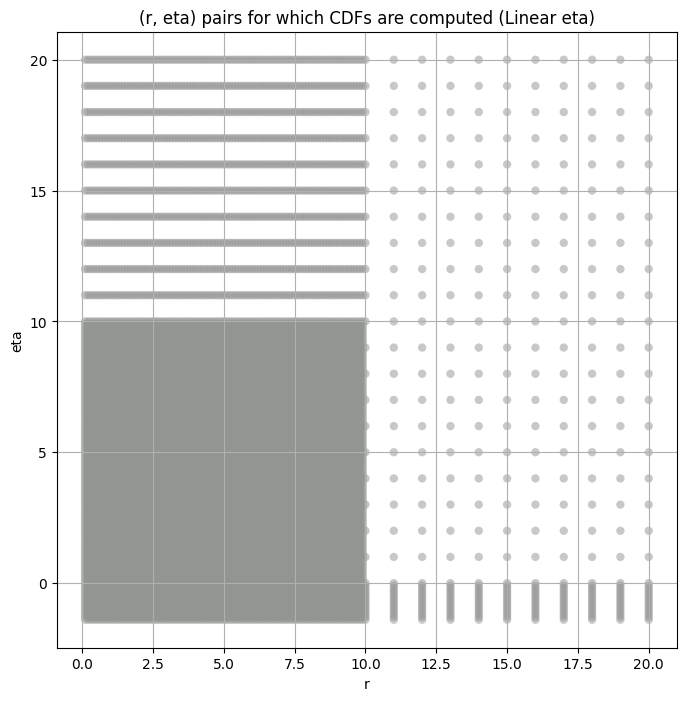

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.013561   0.011274   0.016338   49.807297   26.193740   76.981925   
3     0.217521   0.182485   0.256708   41.785285   33.181702   52.732331   
5     2.124922   1.955512   2.299172    7.918936    6.897348    9.038367   
6     1.602871   1.474974   1.734341    7.894833    7.000770    8.838912   
8     0.153297   0.133375   0.176446   27.836279   17.204713   43.155848   
9     0.036959   0.032704   0.042303   22.688352   11.490171   58.108412   
11    0.023966   0.020228   0.028214   38.853258   27.268229   60.477741   
12    0.010845   0.008920   0.013193   55.613996   35.373178  103.036916   
14    0.000618   0.000498   0.000802   83.286215   35.822122  273.500316   
16    0.000156   0.000108   0.000227  212.922173   92.017210  500.892435   

      total_samples  
band                 
2           98143.0  
3          100000.0  
5          100000.0  
6          100000.0  
8          100000.0  
9          100000.0  
11         100000.0  
12         100000.0  
14         100000.0  
16         100000.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  var_exclude_75  \
band                                                                            
2     0.013561       0.013561        0.012004        0.011175        0.010561   
3     0.217521       0.217521        0.201221        0.189770        0.179942   
5     2.124922       2.124922        2.077669        2.039495        2.005132   
6     1.602871       1.602871        1.570765        1.543117        1.517969   
8     0.153297       0.153297        0.141619        0.134983        0.129863   
9     0.036959       0.036959        0.034445        0.033198        0.032243   
11    0.023966       0.023966        0.021995        0.020793        0.019831   
12    0.010845       0.010845        0.009709        0.009067        0.008565   
14    0.000618       0.000618        0.000543        0.000506        0.000478   
16    0.000156       0.000156        0.000119        0.000103        0.000092   

      var_exclude_100  var_exclude_150  var_exclude_200  var_exclude_250  \
band                                                                       
2            0.010086         0.009385         0.008884         0.008487   
3            0.171296         0.156418         0.144060         0.133792   
5            1.973541         1.916157         1.864758         1.817757   
6            1.494551         1.451752         1.413310         1.377991   
8            0.125625         0.118741         0.113199         0.108524   
9            0.031449         0.030149         0.029078         0.028154   
11           0.019011         0.017644         0.016521         0.015560   
12           0.008143         0.007450         0.006891         0.006420   
14           0.000454         0.000415         0.000384         0.000357   
16           0.000083         0.000070         0.000060         0.000053   

      var_exclude_300  var_exclude_350  var_exclude_500  
band                                                     
2            0.008158         0.007874         0.007191  
3            0.125104         0.117577         0.099541  
5            1.774241         1.733831         1.626221  
6            1.345231         1.314498         1.231850  
8            0.104466         0.100865         0.092021  
9            0.027334         0.026593         0.024704  
11           0.014720         0.013974         0.012141  
12           0.006013         0.005656         0.004794  
14           0.000335         0.000315         0.000267  
16           0.000047         0.000042         0.000031

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.0046214588256136 0.013561364405767686


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.004700281182971389 0.012003875109532245


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.003390167733673344 0.011174692269948541


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.006673182666982136 0.010561133977965405


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0057788766768810396 0.010086145363434659


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.0024339236896175898 0.009385448951060756


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.0030088604554801383 0.008884168463515155


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.0037665197397934377 0.008486668246303456


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.005110112452165298 0.008158176009098865


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.005637264332062464 0.007873569406738074


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.007203949678156664 0.007191265803519367
Number of samples: 100000, Without approximation : 98143.0


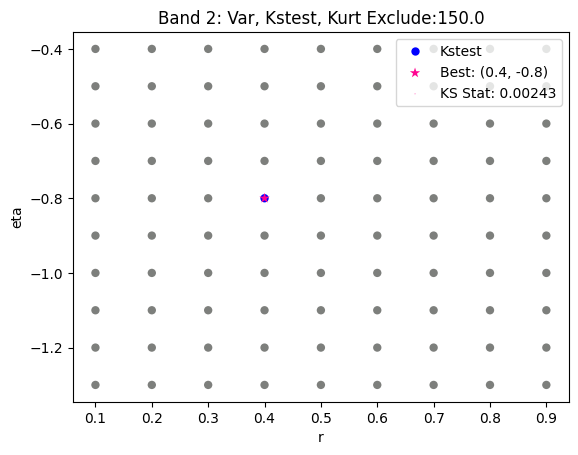

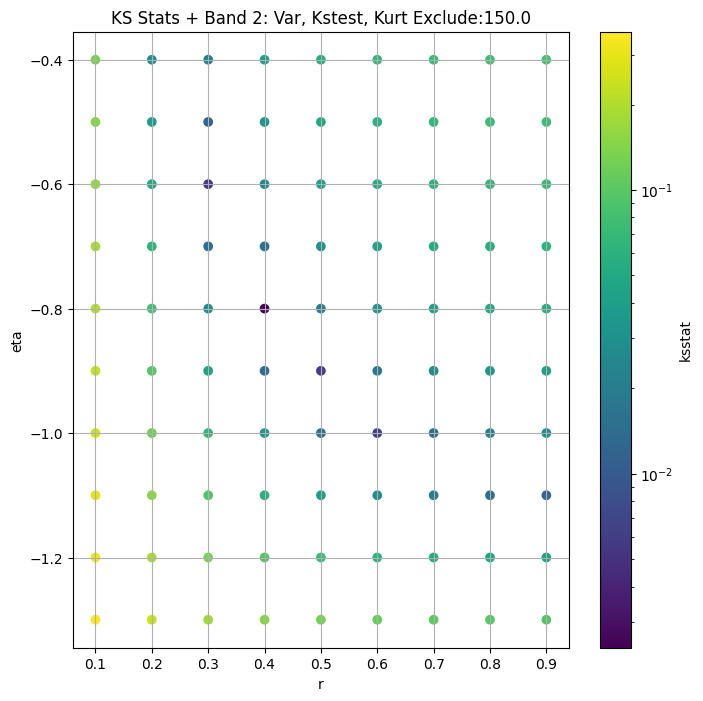

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.02502887673655929 0.21752057706403843


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.021153709361599327 0.20122146326319923


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.018248514123489157 0.1897703143132324


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.016127798193845966 0.17994217723704786


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.017624151875809846 0.17129627445173573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.02047128635926304 0.15641762052385863


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.019645267156209067 0.14405967752259588


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.015834586700798514 0.13379177270994524


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.015278010697630864 0.12510422830630905


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.016237109503855523 0.11757718563454167


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.017325124204097243 0.09954066208331326
Number of samples: 100000, Without approximation : 100000.0


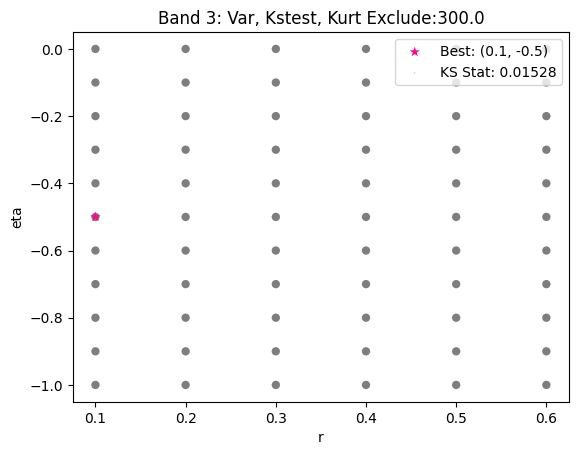

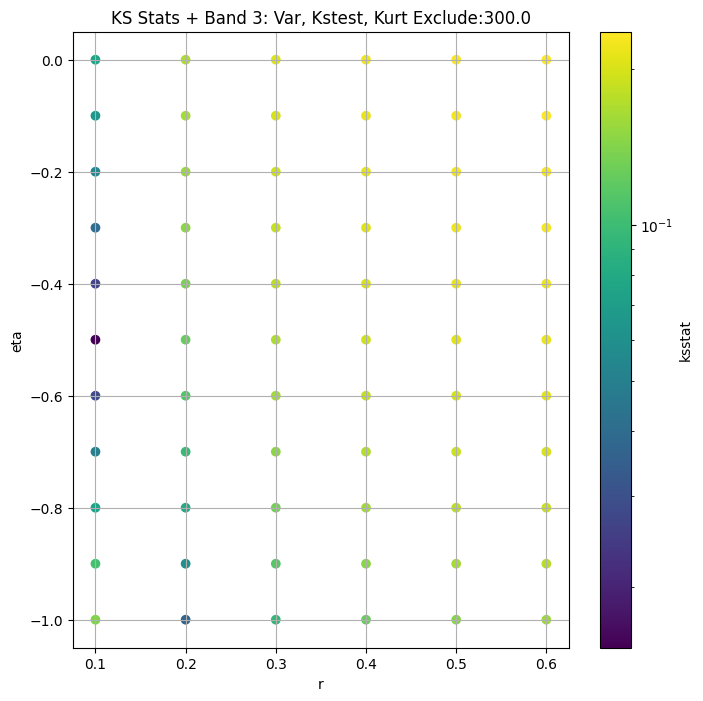

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.011759297621201065 2.124922045147914


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.012439934263559937 2.077669272800163


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.011610941137408903 2.0394952894945906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.010851219341309615 2.0051324468120524


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.010348184884406586 1.9735412455819625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.011706705801738632 1.9161573618058756


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.012949315725857544 1.8647577144653658


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.013510272540867008 1.8177574412766766


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.012441079790341814 1.7742405201479814


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.013081016276627402 1.733830626567502


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.01387219901339043 1.6262207732601162
Number of samples: 100000, Without approximation : 100000.0


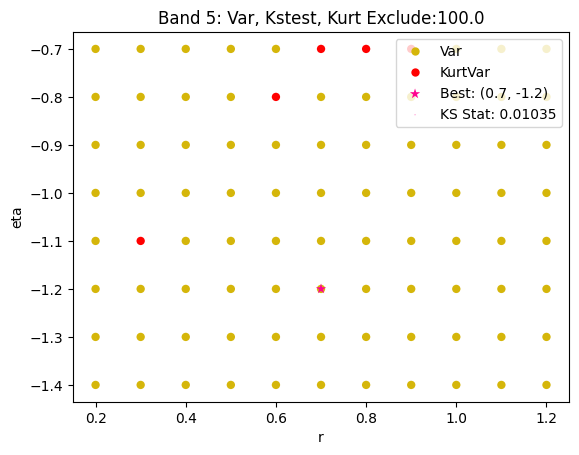

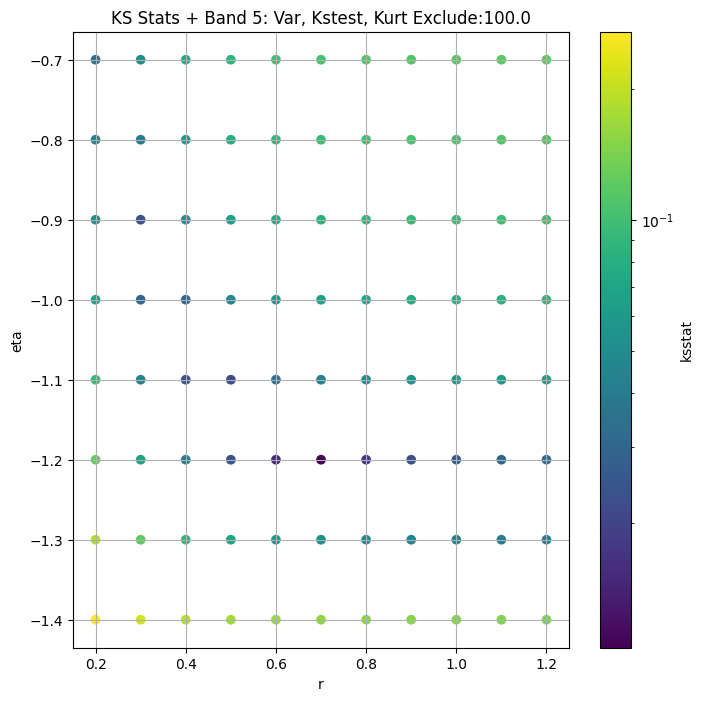

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.011352296613613533 1.6028712106555723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.011601868586620212 1.5707645545649735


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.011822039925339312 1.543116708443627


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.012026712355655111 1.5179691095787504


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.01222815603218258 1.494550503371943


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.013030982785477603 1.4517524528346608


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.014101316324150306 1.4133097830724128


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.013045979398567664 1.3779914934191204


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.012901251574382051 1.345231105493109


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.013761095668663473 1.3144982798238705


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.01498732379371781 1.2318500550411926
Number of samples: 100000, Without approximation : 100000.0


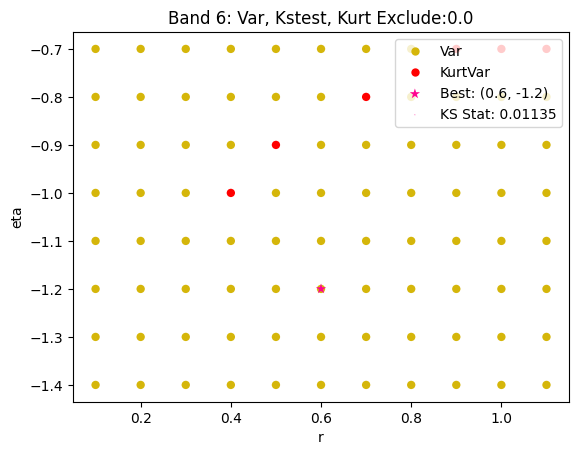

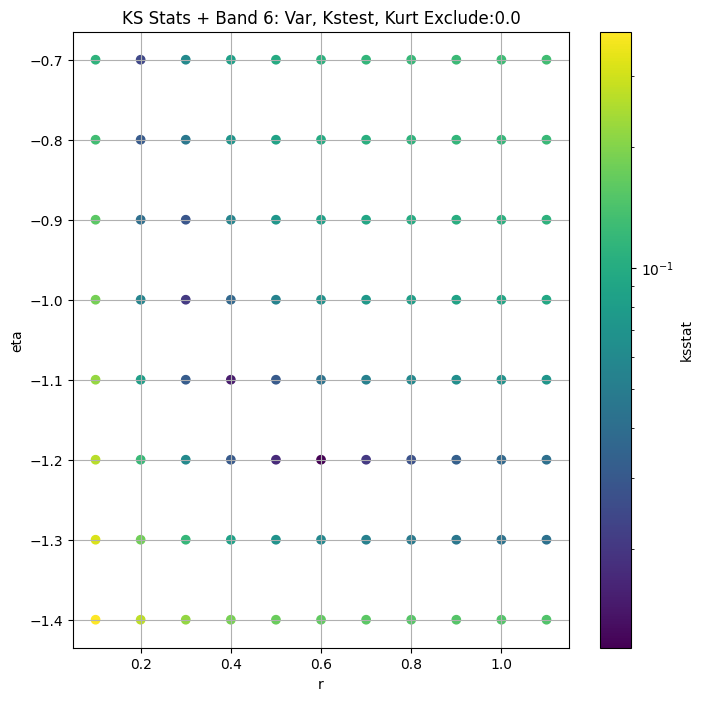

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.003857003677780413 0.1532966409829672


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.006123025580975994 0.1416193607724913


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.005677115111102193 0.1349828614435


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.004305387503673375 0.12986342255293462


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.005094861622024341 0.1256249239415752


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.008055318575104872 0.11874090506700112


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.006924398140558674 0.11319916725038534


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.004572455084682001 0.10852382227032846


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.006134933631706911 0.1044657587460275


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.0077228603218104375 0.10086501810462657


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.008933303950056481 0.09202065250805813
Number of samples: 100000, Without approximation : 100000.0


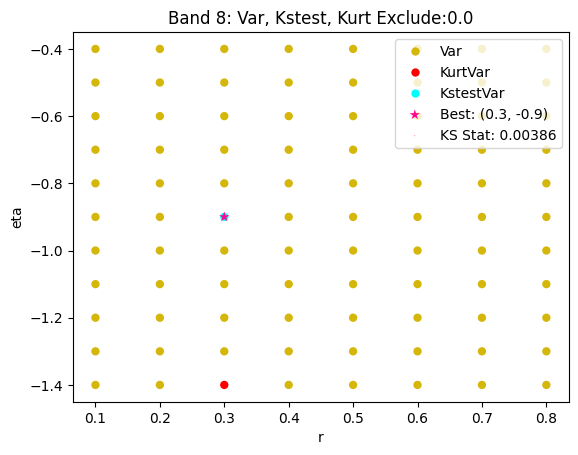

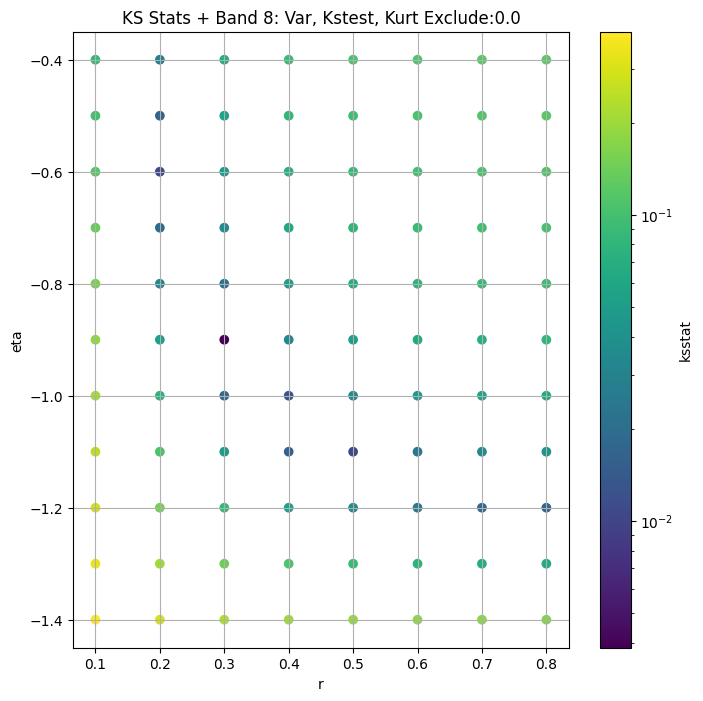

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.00405172883633384 0.03695874270544053


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.005472723454920336 0.03444485940610748


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.0032191795337983553 0.03319776160960966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.0034996006132733126 0.03224340376894359


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.003922545893078493 0.03144946538745036


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.005752741922376181 0.03014858464434146


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.005522569542093292 0.02907819761247289


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.006155111486241843 0.028153693957367453


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.007266409816157393 0.02733420598341384


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.008008235081808035 0.02659349176369611


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.009614833259169342 0.024704452956869245
Number of samples: 100000, Without approximation : 100000.0


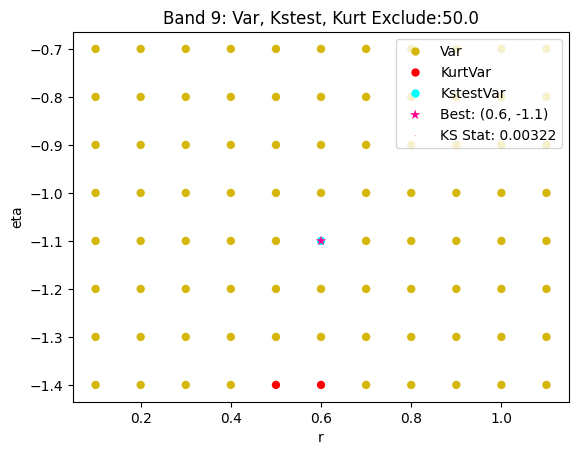

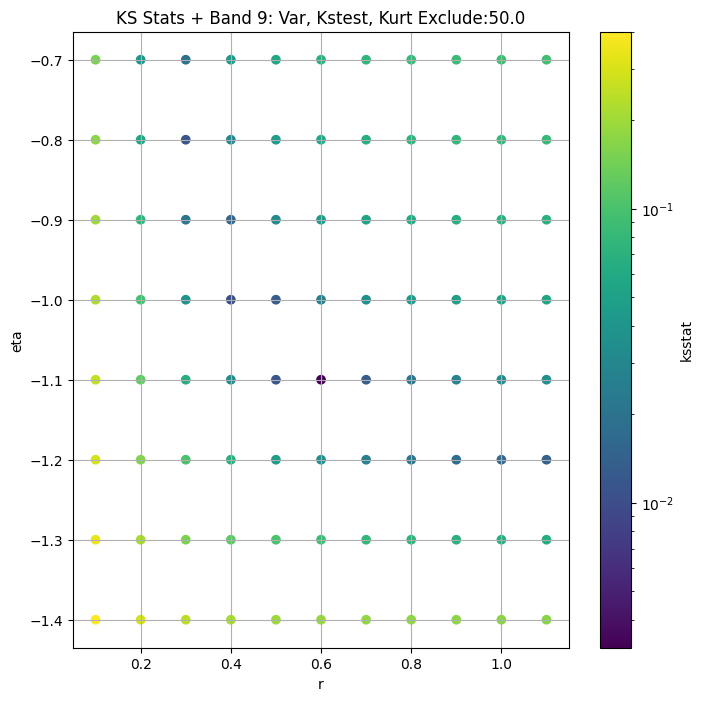

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.008812979845078006 0.023965560799922642


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.008805588815466114 0.021994822902732417


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.009625018619607129 0.02079348705070658


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.010367120292123 0.0198310202077948


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.01106251208896375 0.01901071850173647


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.01242639855979949 0.017644430200489284


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.013726021782132447 0.0165212822048325


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.015041800193942578 0.015559895482190042


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.012731953293368847 0.01472000359227837


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.011656743648161834 0.013974103546066962


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.011337765837571415 0.01214132777722364
Number of samples: 100000, Without approximation : 100000.0


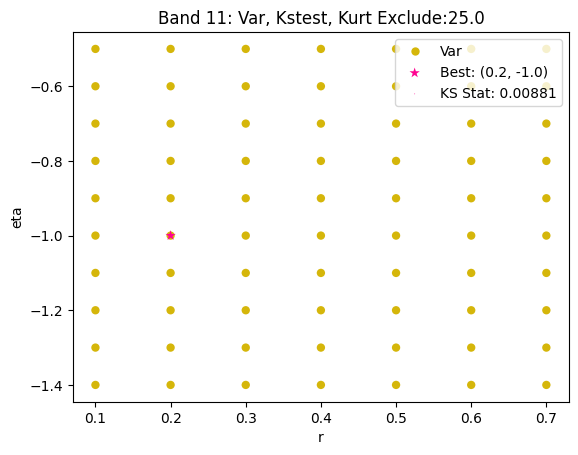

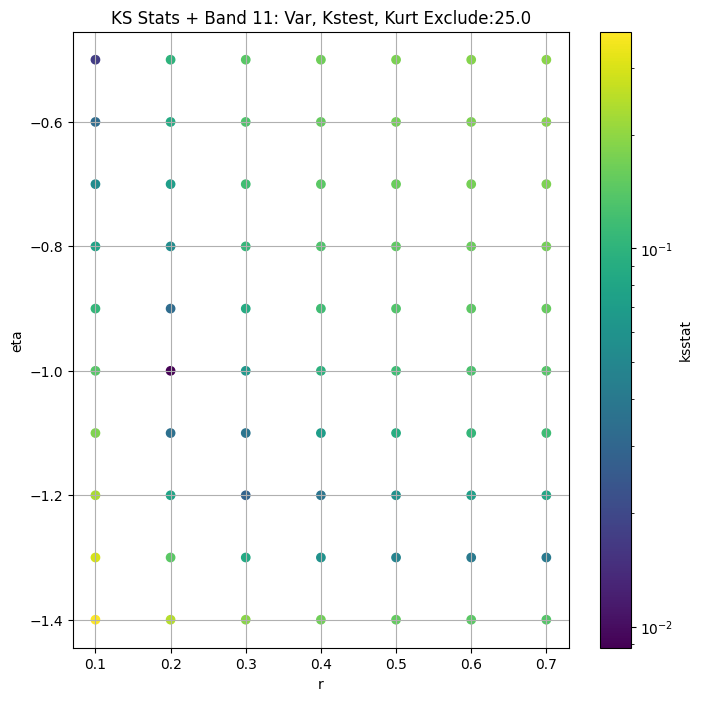

####
Band  12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 0 0.013560210806724038 0.010845479454738077


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 25 0.010331238705904022 0.009708881079059236


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 50 0.00840179920419826 0.00906707311861869


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 75 0.00930105623650598 0.008564819425997898


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 100 0.01014093793522524 0.00814304057915786


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 150 0.01091453466049197 0.007450480128190931


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 200 0.011235109681735366 0.006891028448886643


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 250 0.012445035639137257 0.006419805468040665


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 300 0.012976185550641062 0.006013057732174651


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 350 0.013170879876563568 0.0056558137874658946


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
12 500 0.01548434696978307 0.004794193905731963
Number of samples: 100000, Without approximation : 100000.0


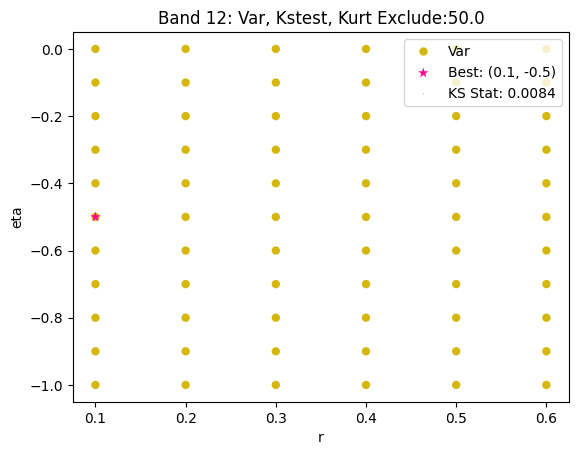

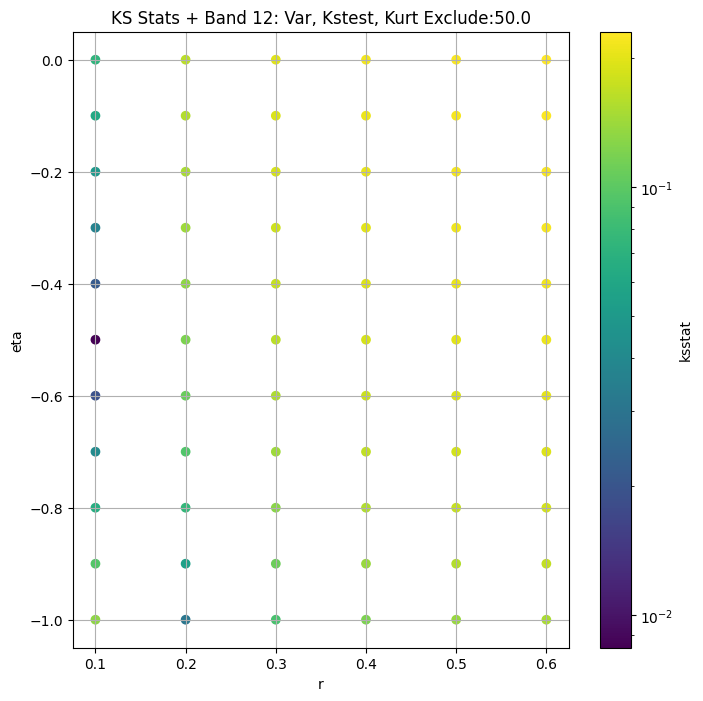

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.019507040327831238 0.0006178668955948469


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.012581911611449614 0.0005425548221315615


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.0125862193862471 0.0005059785601041598


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.014455716342667901 0.0004775603055501479


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.014904973854534376 0.0004538498977714629


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.009918129938397247 0.0004150408621952053


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.009713625530889558 0.00038378179760739466


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.012096136807736524 0.00035742892724767856


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.010599206860189923 0.0003346823092088549


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.011584095676766291 0.00031473399280045435


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.013421805246178604 0.000266582946973808
Number of samples: 100000, Without approximation : 100000.0


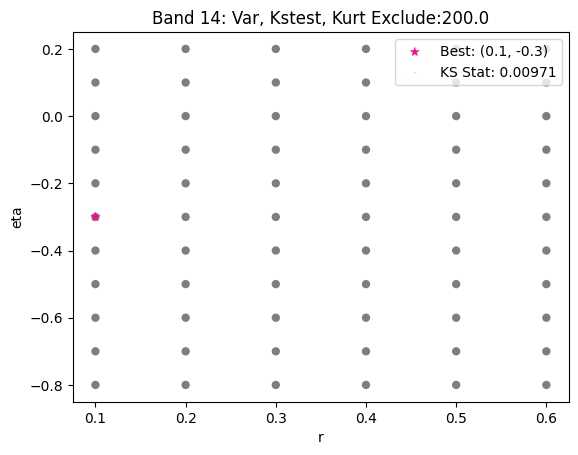

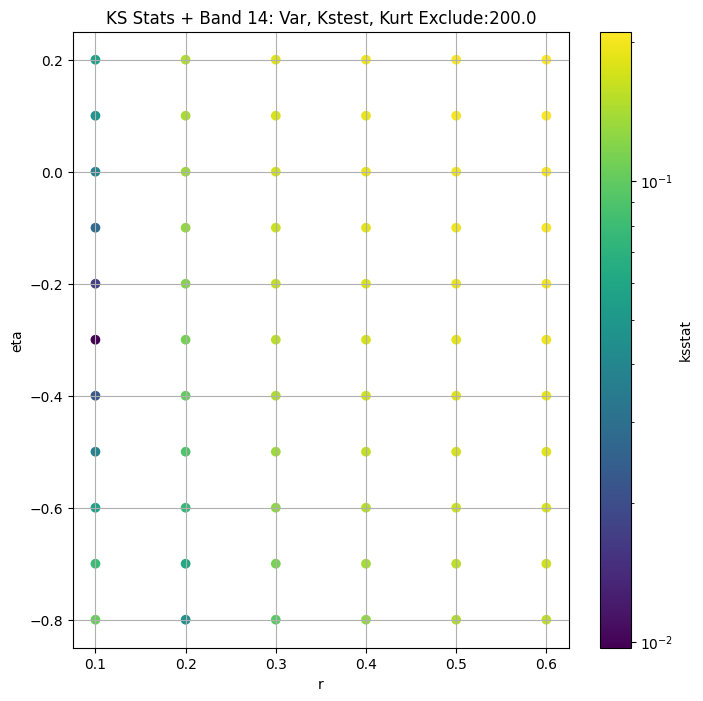

####
Band  16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 0 0.03534139284766946 0.00015594638531990935


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 25 0.028222669462425742 0.00011920519874679944


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 50 0.03233345308561886 0.0001030825004572723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 75 0.026647927761237145 9.171332941074125e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 100 0.021802770192819287 8.292414788202801e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 150 0.026434175425656792 6.974848574092717e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 200 0.020133633583811927 6.015271721893437e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 250 0.019589987401203324 5.273954408262017e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 300 0.020304162280612936 4.6795935952021874e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 350 0.014415210588101246 4.19251734218273e-05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
16 500 0.010903502348599103 3.1486512836773735e-05
Number of samples: 100000, Without approximation : 100000.0


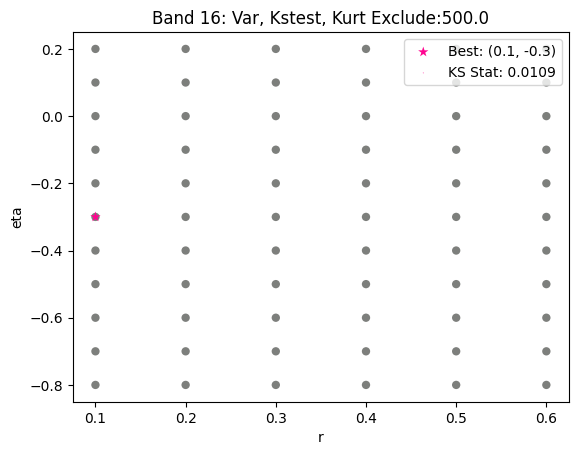

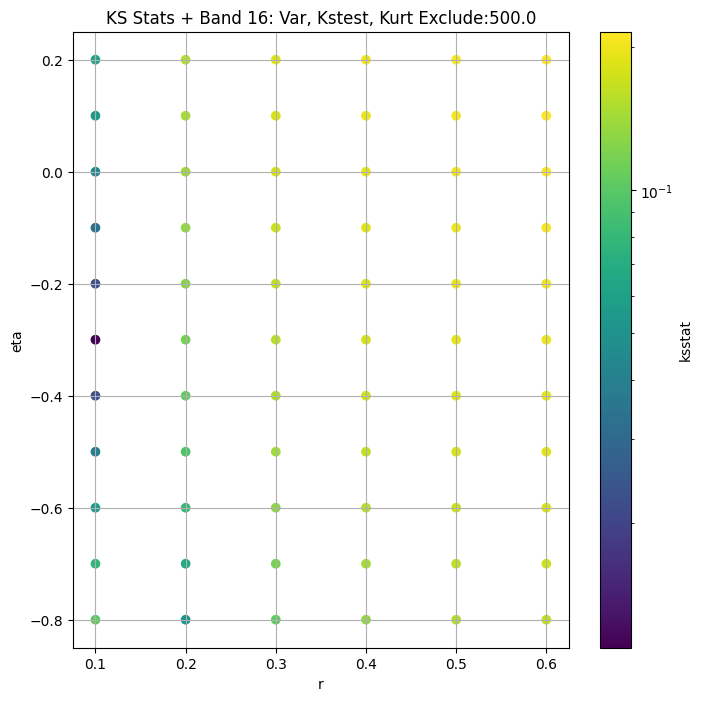

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.013561   0.011274   0.016338   49.807297   26.193740   76.981925   
3     0.217521   0.182485   0.256708   41.785285   33.181702   52.732331   
5     2.124922   1.955512   2.299172    7.918936    6.897348    9.038367   
6     1.602871   1.474974   1.734341    7.894833    7.000770    8.838912   
8     0.153297   0.133375   0.176446   27.836279   17.204713   43.155848   
9     0.036959   0.032704   0.042303   22.688352   11.490171   58.108412   
11    0.023966   0.020228   0.028214   38.853258   27.268229   60.477741   
12    0.010845   0.008920   0.013193   55.613996   35.373178  103.036916   
14    0.000618   0.000498   0.000802   83.286215   35.822122  273.500316   
16    0.000156   0.000108   0.000227  212.922173   92.017210  500.892435   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           98143.0             0.002434        0.4         -0.8   
3          100000.0             0.015278        0.1         -0.5   
5          100000.0             0.010348        0.7         -1.2   
6          100000.0             0.011352        0.6         -1.2   
8          100000.0             0.003857        0.3         -0.9   
9          100000.0             0.003219        0.6         -1.1   
11         100000.0             0.008806        0.2         -1.0   
12         100000.0             0.008402        0.1         -0.5   
14         100000.0             0.009714        0.1         -0.3   
16         100000.0             0.010904        0.1         -0.3   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.041126e-03                   150.0            0.009385   
3      3.731989e-13                   300.0            0.125104   
5      4.305041e+00                   100.0            1.973541   
6      2.624884e+00                     0.0            1.602871   
8      3.820100e-03                     0.0            0.153297   
9      3.775592e-02                    50.0            0.033198   
11     1.562514e-05                    25.0            0.021995   
12     2.704802e-14                    50.0            0.009067   
14     2.998446e-16                   200.0            0.000384   
16     2.460007e-17                   500.0            0.000031   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004333  
3                    0.004293  
5                    0.004293  
6                    0.004293  
8                    0.004293  
9                    0.004293  
11                   0.004293  
12                   0.004293  
14                   0.004293  
16                   0.004293

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + 100 = 250, ksstat: 0.003655707097375307, var: 0.008486668246303456


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + 75 = 225, ksstat: 0.003236575284099886, var: 0.008676204719407967


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + 50 = 200, ksstat: 0.0029644625647824094, var: 0.008884168463515155


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + 25 = 175, ksstat: 0.002622635552162156, var: 0.00911519299277662


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + 0 = 150, ksstat: 0.0022537141477006117, var: 0.009385448951060756


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + -25 = 125, ksstat: 0.001948510125921568, var: 0.009703274751518956


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + -50 = 100, ksstat: 0.0018895350311477488, var: 0.010086145363434659


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + -75 = 75, ksstat: 0.0022233958816869626, var: 0.010561133977965405


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
band 2, 150.0 + -100 = 50, ksstat: 0.002226123801710278, var: 0.011174692269948541
Number of samples: 100000, Without approximation : 98143.0


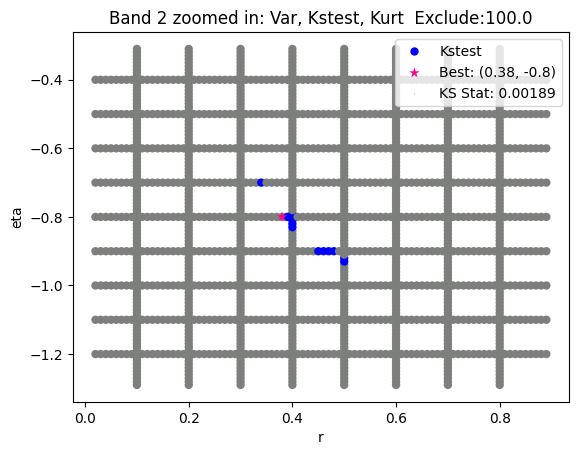

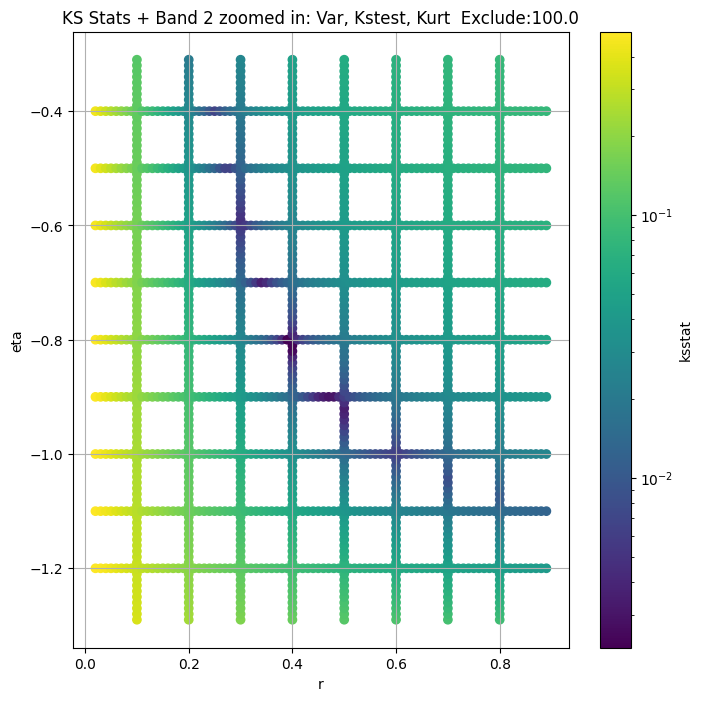

Band 3


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + 100 = 400, ksstat: 0.015696239083415442, var: 0.11088823288181206


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + 75 = 375, ksstat: 0.015911691570078965, var: 0.11413163433475729


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + 50 = 350, ksstat: 0.015609825829093746, var: 0.11757718563454167


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + 25 = 325, ksstat: 0.015209180790919229, var: 0.12121651643834504


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + 0 = 300, ksstat: 0.014744023808843782, var: 0.12510422830630905


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + -25 = 275, ksstat: 0.014798345179795967, var: 0.12927898606588406


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + -50 = 250, ksstat: 0.014446185723541317, var: 0.13379177270994524


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + -75 = 225, ksstat: 0.014233472305055703, var: 0.1387036815914505


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 3, 300.0 + -100 = 200, ksstat: 0.013836691365306665, var: 0.14405967752259588
Number of samples: 100000, Without approximation : 100000.0


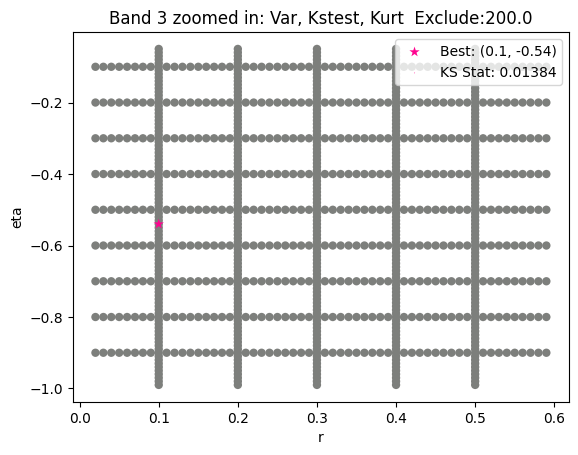

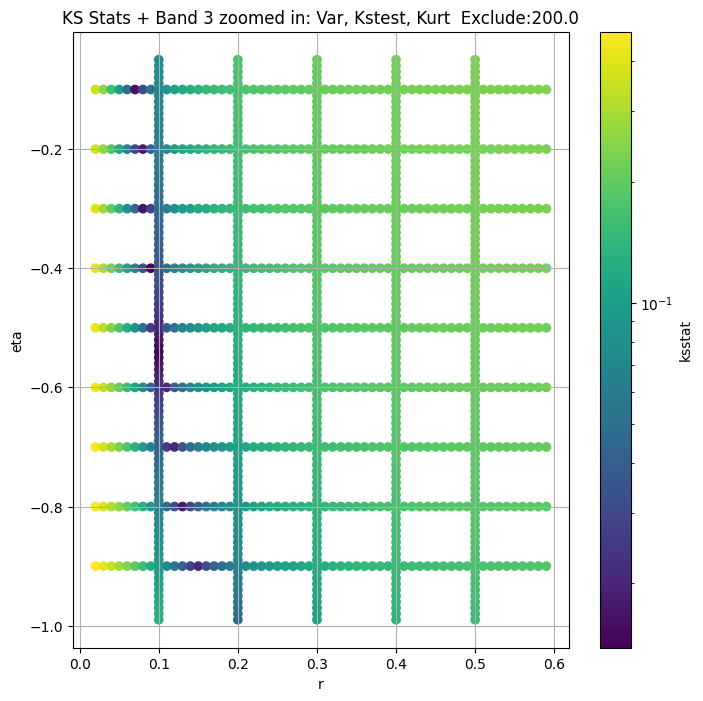

Band 5


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 100 = 200, ksstat: 0.010605084766500461, var: 1.8647577144653658


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 75 = 175, ksstat: 0.011209407742128086, var: 1.8898247124452556


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 50 = 150, ksstat: 0.010966660885130125, var: 1.9161573618058756


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 25 = 125, ksstat: 0.010665413841332141, var: 1.9440180332545258


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + 0 = 100, ksstat: 0.010348184884406586, var: 1.9735412455819625


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + -25 = 75, ksstat: 0.010030204610596893, var: 2.0051324468120524


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + -50 = 50, ksstat: 0.009931367447262196, var: 2.0394952894945906


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + -75 = 25, ksstat: 0.009633268124514524, var: 2.077669272800163


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
band 5, 100.0 + -100 = 0, ksstat: 0.009053515325443684, var: 2.124922045147914
Number of samples: 100000, Without approximation : 100000.0


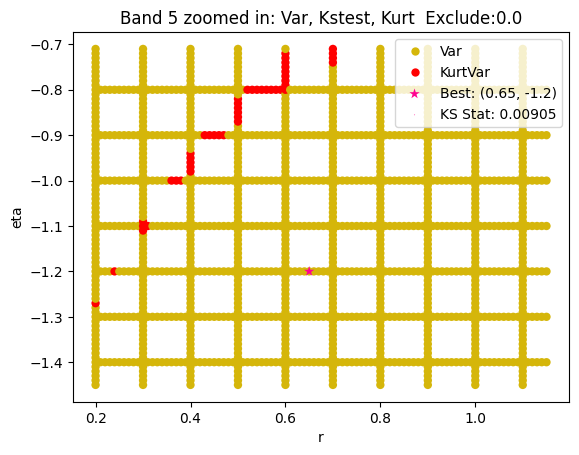

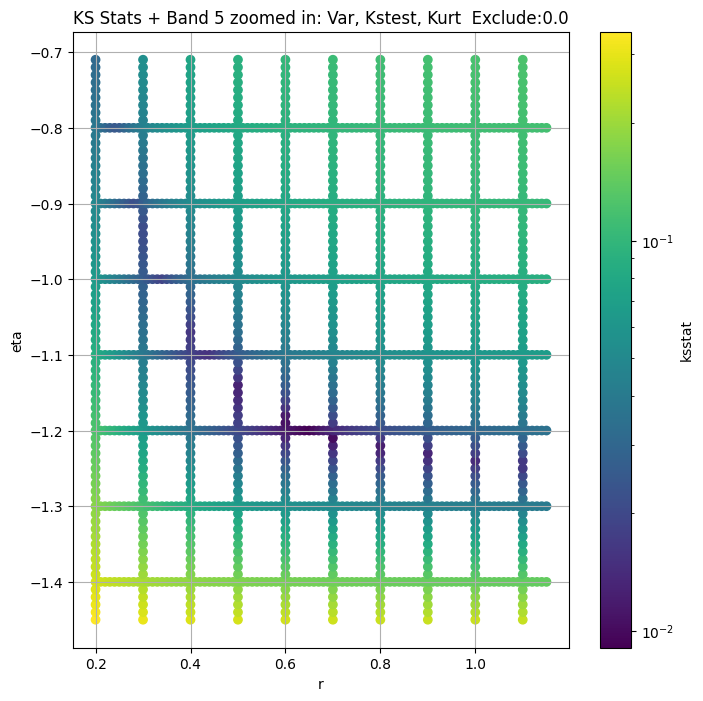

Band 6


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 100 = 100, ksstat: 0.011103530279443108, var: 1.494550503371943


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 75 = 75, ksstat: 0.011087056963101083, var: 1.5179691095787504


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 50 = 50, ksstat: 0.011066476160865424, var: 1.543116708443627


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 25 = 25, ksstat: 0.011217180028940343, var: 1.5707645545649735


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
band 6, 0.0 + 0 = 0, ksstat: 0.011352296613613533, var: 1.6028712106555723
Number of samples: 100000, Without approximation : 100000.0


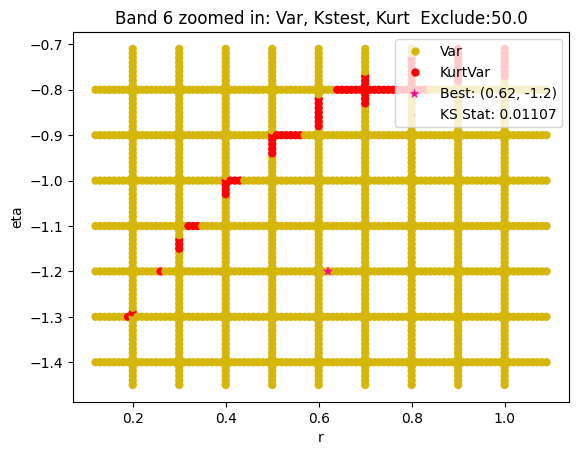

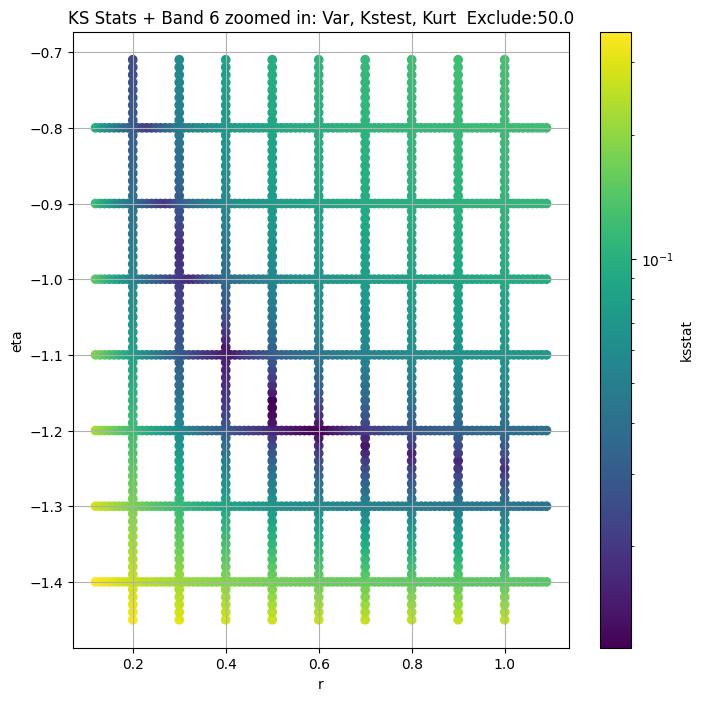

Band 8


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.003905447202656509, var: 0.1256249239415752


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.004143758936084346, var: 0.12986342255293462


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.002945608262916455, var: 0.1349828614435


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.002213285053574543, var: 0.1416193607724913


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.002298617846243356, var: 0.1532966409829672
Number of samples: 100000, Without approximation : 100000.0


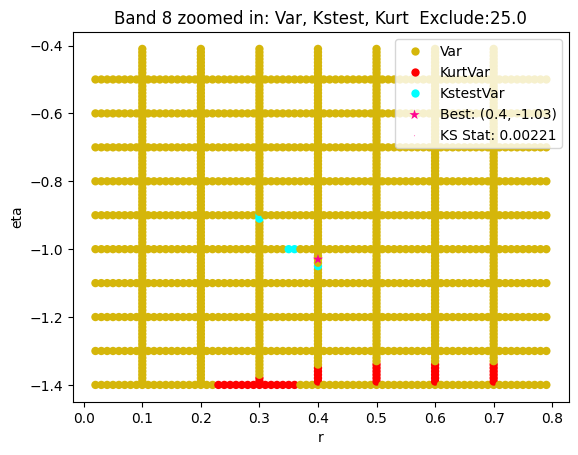

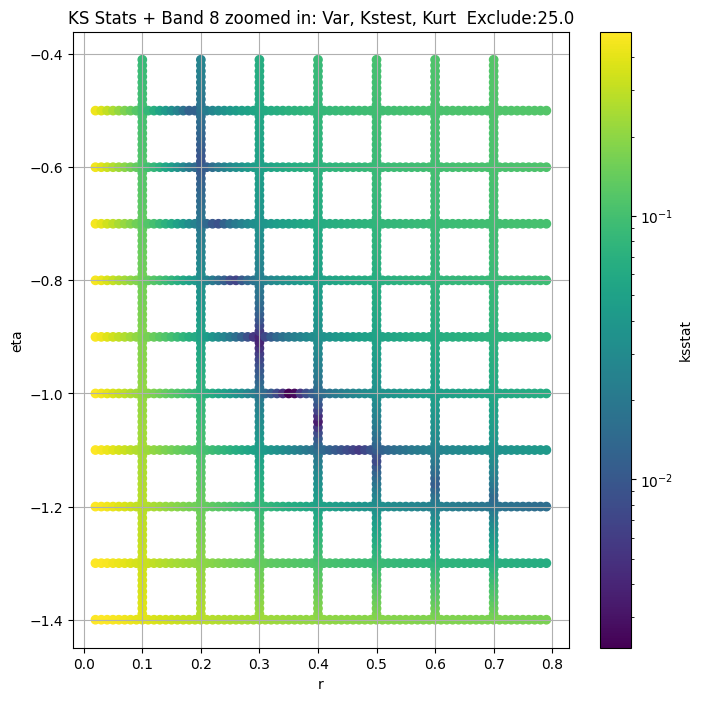

Band 9


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 100 = 150, ksstat: 0.004281557063101918, var: 0.03014858464434146


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 75 = 125, ksstat: 0.0038761529344549586, var: 0.03076122544923623


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 50 = 100, ksstat: 0.0033234800413433074, var: 0.03144946538745036


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 25 = 75, ksstat: 0.0031584181450542426, var: 0.03224340376894359


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + 0 = 50, ksstat: 0.0032191795337983553, var: 0.03319776160960966


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + -25 = 25, ksstat: 0.0025265706593630977, var: 0.03444485940610748


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
band 9, 50.0 + -50 = 0, ksstat: 0.0027674203588254898, var: 0.03695874270544053
Number of samples: 100000, Without approximation : 100000.0


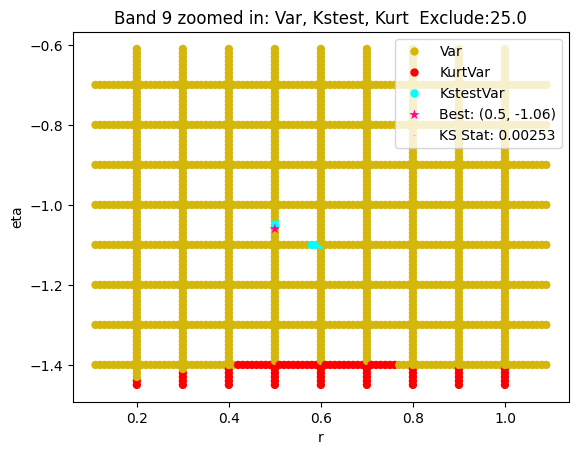

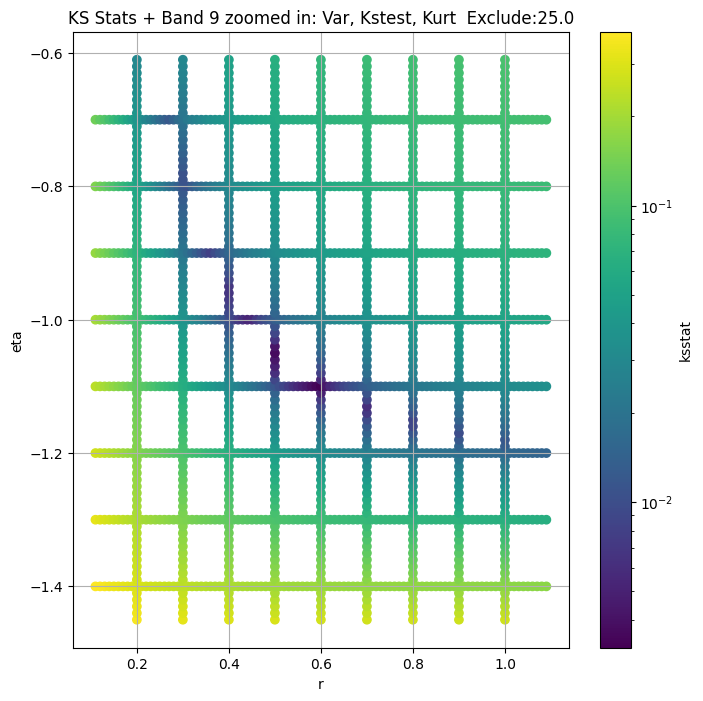

Band 11


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 100 = 125, ksstat: 0.00762286700550216, var: 0.018290189827206052


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 75 = 100, ksstat: 0.007624866866471958, var: 0.01901071850173647


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 50 = 75, ksstat: 0.007235114029696121, var: 0.0198310202077948


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 25 = 50, ksstat: 0.007262515867457374, var: 0.02079348705070658


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + 0 = 25, ksstat: 0.006102200886125248, var: 0.021994822902732417


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 11, 25.0 + -25 = 0, ksstat: 0.006939563612724561, var: 0.023965560799922642
Number of samples: 100000, Without approximation : 100000.0


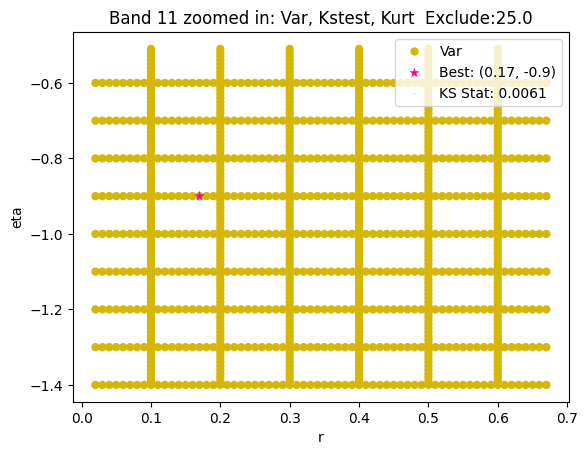

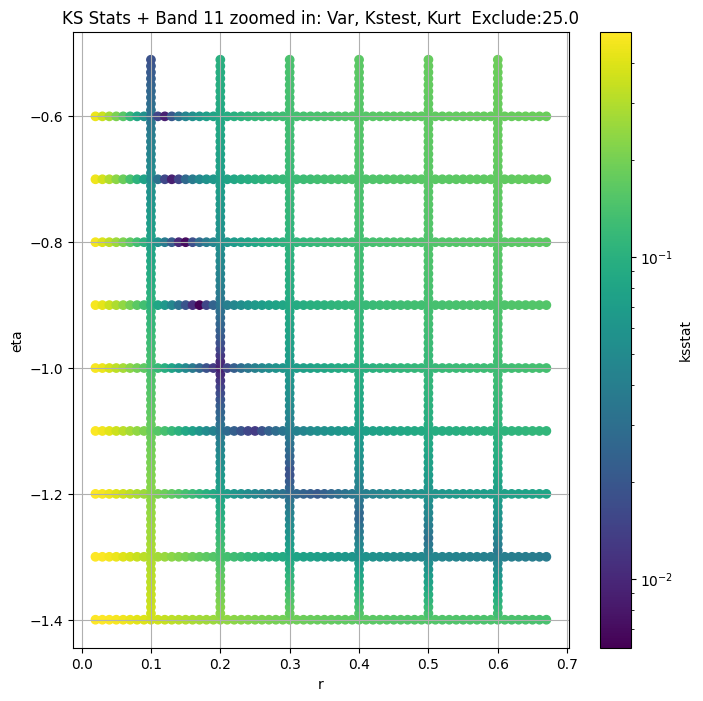

Band 12


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 100 = 150, ksstat: 0.009495998368799219, var: 0.007450480128190931


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 75 = 125, ksstat: 0.008606571036518795, var: 0.007776032658632851


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 50 = 100, ksstat: 0.009282629001013853, var: 0.00814304057915786


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 25 = 75, ksstat: 0.008711033097007197, var: 0.008564819425997898


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + 0 = 50, ksstat: 0.0081104352300706, var: 0.00906707311861869


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + -25 = 25, ksstat: 0.007689484475074546, var: 0.009708881079059236


  0%|          | 0/972 [00:00<?, ?it/s]

Finding Minimum after computing 972 CDFs
band 12, 50.0 + -50 = 0, ksstat: 0.007803270352571834, var: 0.010845479454738077
Number of samples: 100000, Without approximation : 100000.0


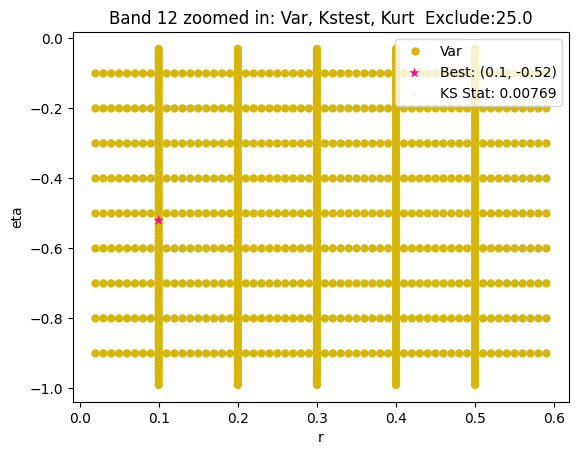

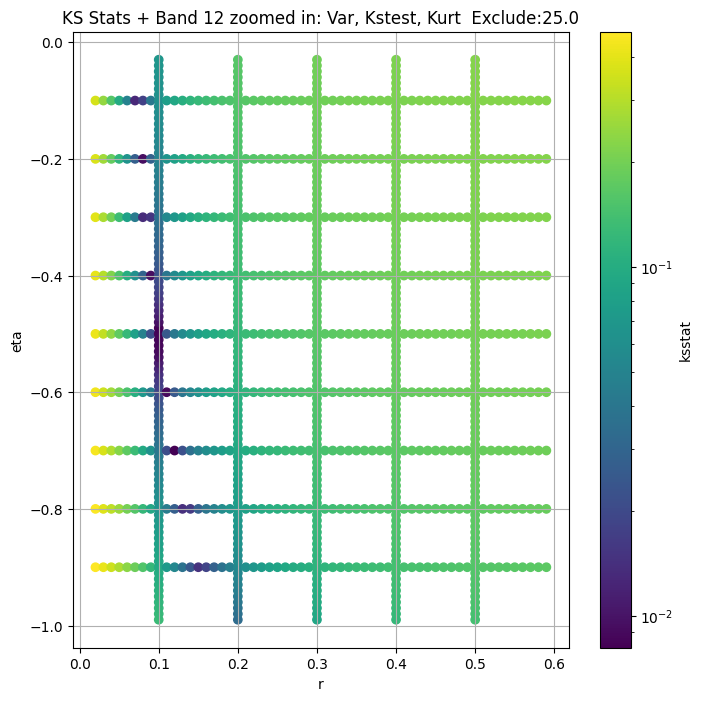

Band 14


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 100 = 300, ksstat: 0.010511125887336152, var: 0.0003346823092088549


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 75 = 275, ksstat: 0.010193162005986411, var: 0.0003456620830224593


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 50 = 250, ksstat: 0.009863605022220886, var: 0.00035742892724767856


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 25 = 225, ksstat: 0.009136253398309258, var: 0.0003700923066964318


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + 0 = 200, ksstat: 0.009163281877488223, var: 0.00038378179760739466


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + -25 = 175, ksstat: 0.008829573111271971, var: 0.0003986725574468534


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + -50 = 150, ksstat: 0.008760461851025969, var: 0.0004150408621952053


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + -75 = 125, ksstat: 0.00881329716578632, var: 0.0004332848351724821


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 14, 200.0 + -100 = 100, ksstat: 0.008490610902204265, var: 0.0004538498977714629
Number of samples: 100000, Without approximation : 100000.0


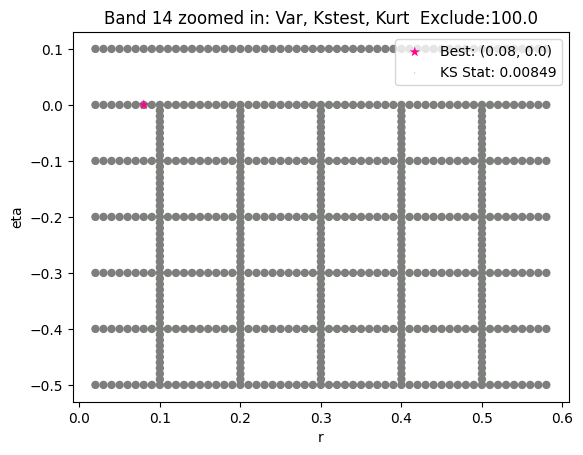

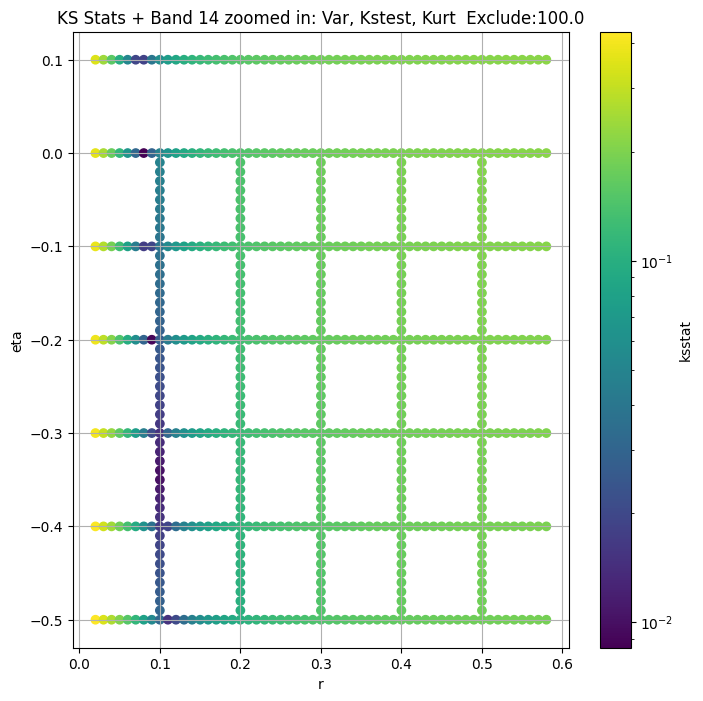

Band 16


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 100 = 600, ksstat: 0.010454812666250275, var: 2.6698116657549537e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 75 = 575, ksstat: 0.010136035594672788, var: 2.7778492054272718e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 50 = 550, ksstat: 0.010039038895919061, var: 2.8931108780565384e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 25 = 525, ksstat: 0.01076183177190726, var: 3.016430757778984e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + 0 = 500, ksstat: 0.010903502348599103, var: 3.1486512836773735e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + -25 = 475, ksstat: 0.011697289388147514, var: 3.2904764265517946e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + -50 = 450, ksstat: 0.01043108330670578, var: 3.443159533883187e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + -75 = 425, ksstat: 0.011699751528880253, var: 3.607965163484227e-05


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 16, 500.0 + -100 = 400, ksstat: 0.013041774309390852, var: 3.786573700022988e-05
Number of samples: 100000, Without approximation : 100000.0


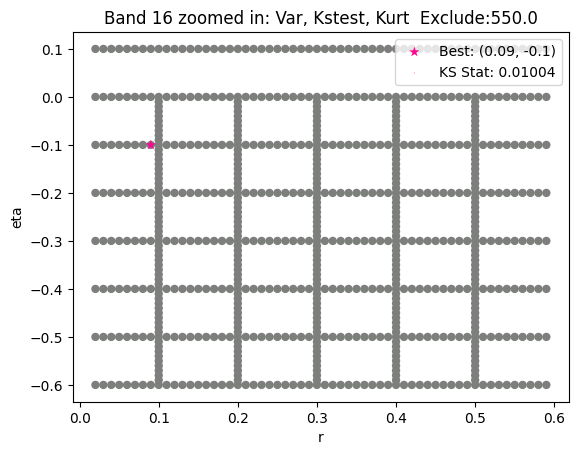

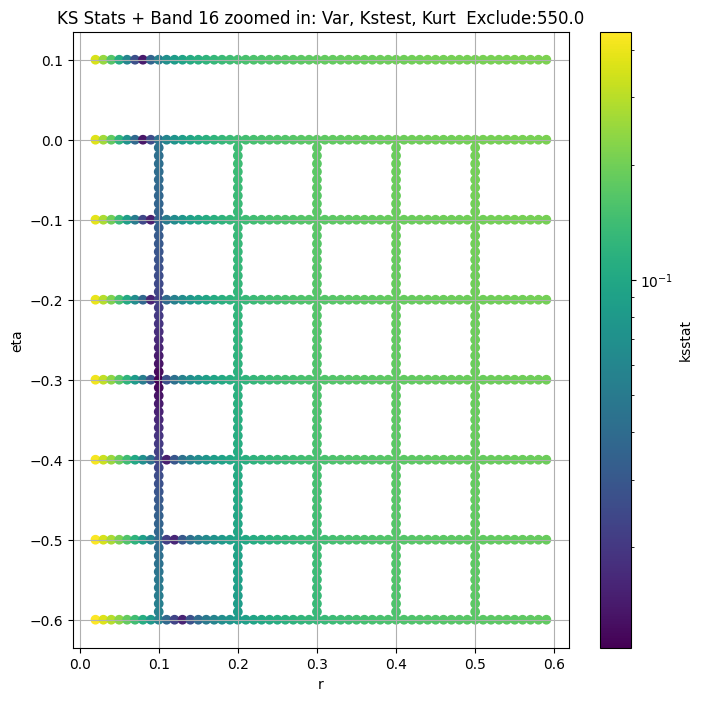

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.013561   0.011274   0.016338   49.807297   26.193740   76.981925   
3     0.217521   0.182485   0.256708   41.785285   33.181702   52.732331   
5     2.124922   1.955512   2.299172    7.918936    6.897348    9.038367   
6     1.602871   1.474974   1.734341    7.894833    7.000770    8.838912   
8     0.153297   0.133375   0.176446   27.836279   17.204713   43.155848   
9     0.036959   0.032704   0.042303   22.688352   11.490171   58.108412   
11    0.023966   0.020228   0.028214   38.853258   27.268229   60.477741   
12    0.010845   0.008920   0.013193   55.613996   35.373178  103.036916   
14    0.000618   0.000498   0.000802   83.286215   35.822122  273.500316   
16    0.000156   0.000108   0.000227  212.922173   92.017210  500.892435   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           98143.0             0.002434        0.4         -0.8   
3          100000.0             0.015278        0.1         -0.5   
5          100000.0             0.010348        0.7         -1.2   
6          100000.0             0.011352        0.6         -1.2   
8          100000.0             0.003857        0.3         -0.9   
9          100000.0             0.003219        0.6         -1.1   
11         100000.0             0.008806        0.2         -1.0   
12         100000.0             0.008402        0.1         -0.5   
14         100000.0             0.009714        0.1         -0.3   
16         100000.0             0.010904        0.1         -0.3   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      1.041126e-03                   150.0            0.010086   
3      3.731989e-13                   300.0            0.144060   
5      4.305041e+00                   100.0            2.124922   
6      2.624884e+00                     0.0            1.543117   
8      3.820100e-03                     0.0            0.141619   
9      3.775592e-02                    50.0            0.034445   
11     1.562514e-05                    25.0            0.021995   
12     2.704802e-14                    50.0            0.009709   
14     2.998446e-16                   200.0            0.000454   
16     2.460007e-17                   500.0            0.000029   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004333          0.001890    0.38     -0.80   
3                    0.004293          0.013837    0.10     -0.54   
5                    0.004293          0.009054    0.65     -1.20   
6                    0.004293          0.011066    0.62     -1.20   
8                    0.004293          0.002213    0.40     -1.03   
9                    0.004293          0.002527    0.50     -1.06   
11                   0.004293          0.006102    0.17     -0.90   
12                   0.004293          0.007689    0.10     -0.52   
14                   0.004293          0.008491    0.08      0.00   
16                   0.004293          0.010039    0.09     -0.10   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     8.482768e-04                100.0       496846  
3     5.754224e-13                200.0         9375  
5     4.077315e+00                  0.0        23728  
6     2.703689e+00                 50.0        15819  
8     3.234321e-02                 25.0       379687  
9     2.082015e-02                 25.0       284764  
11    7.681850e-07                 25.0        50000  
12    3.347668e-14                 25.0        31639  
14    2.249056e-21                100.0        25000  
16    8.307660e-20                550.

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

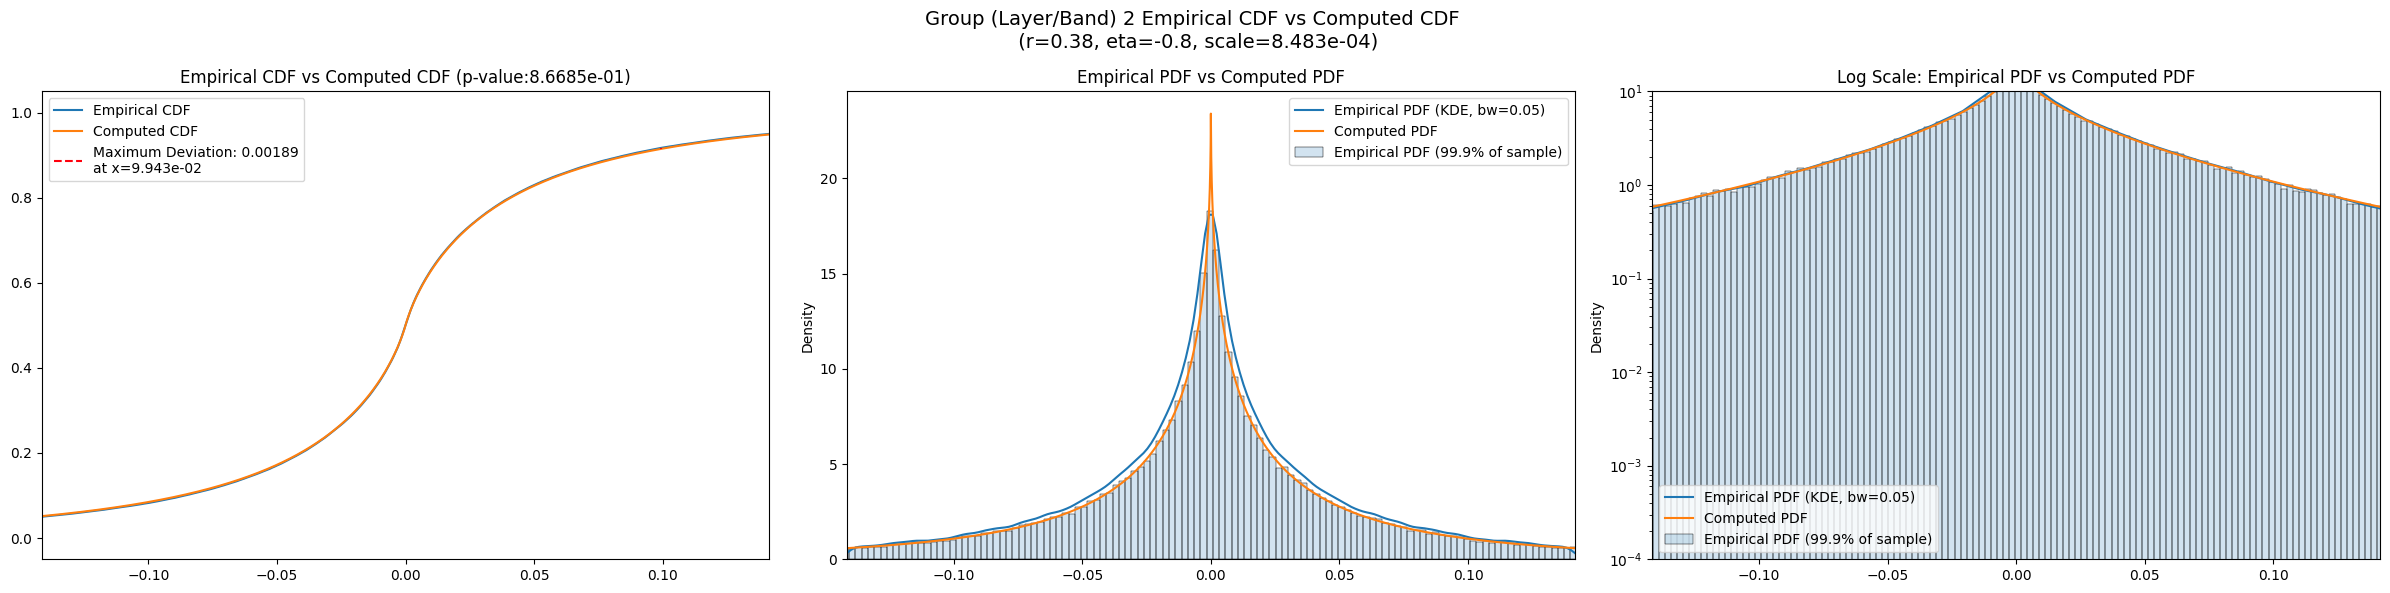

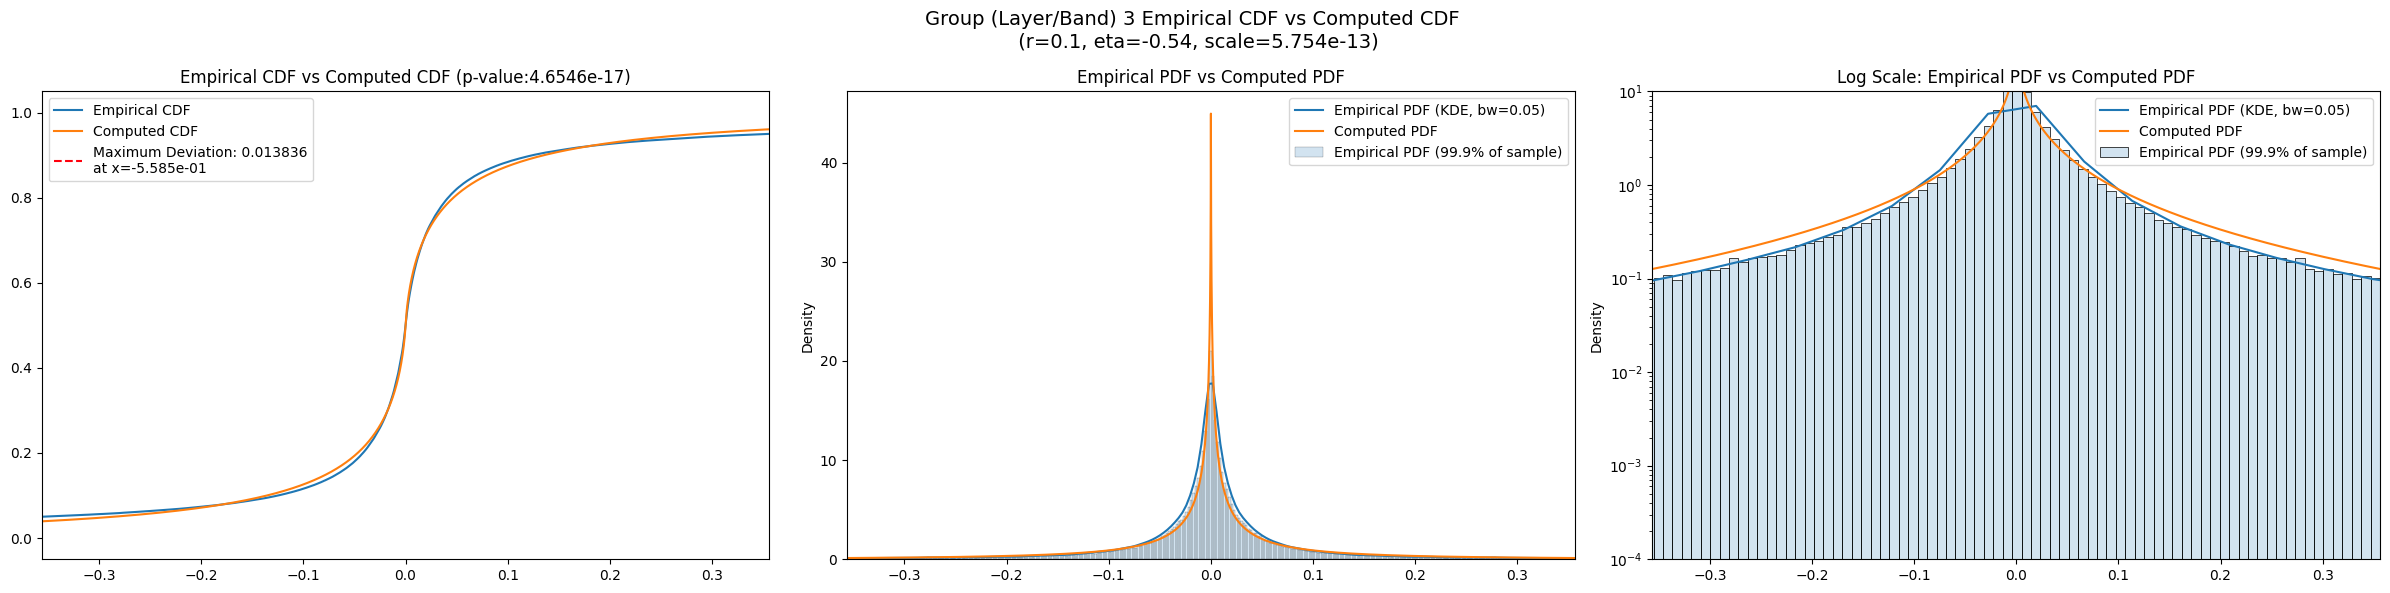

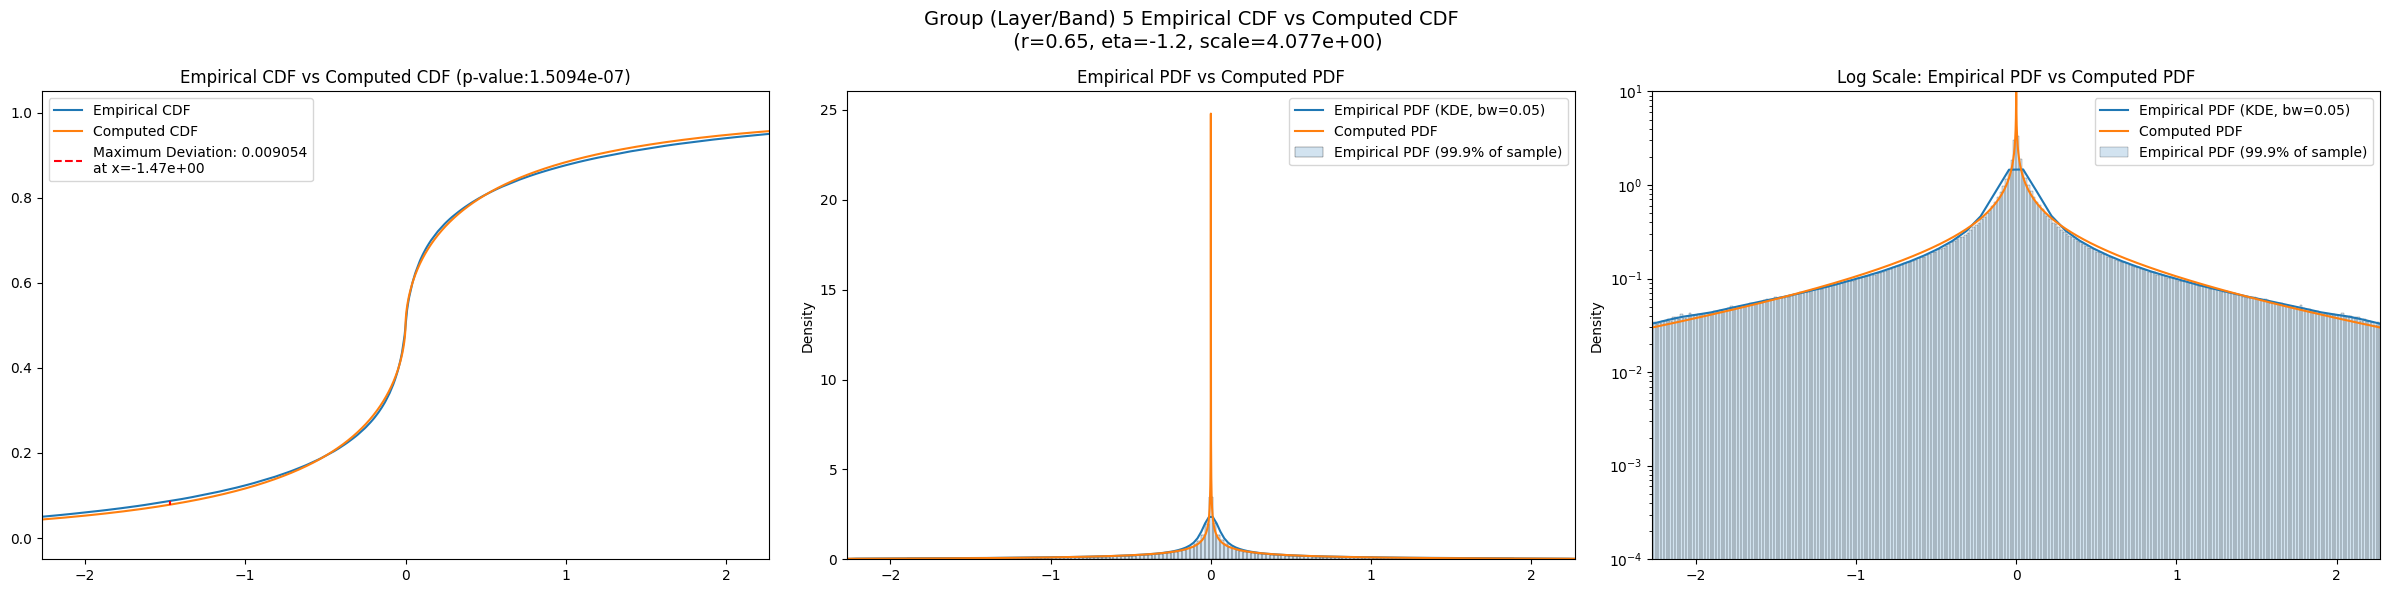

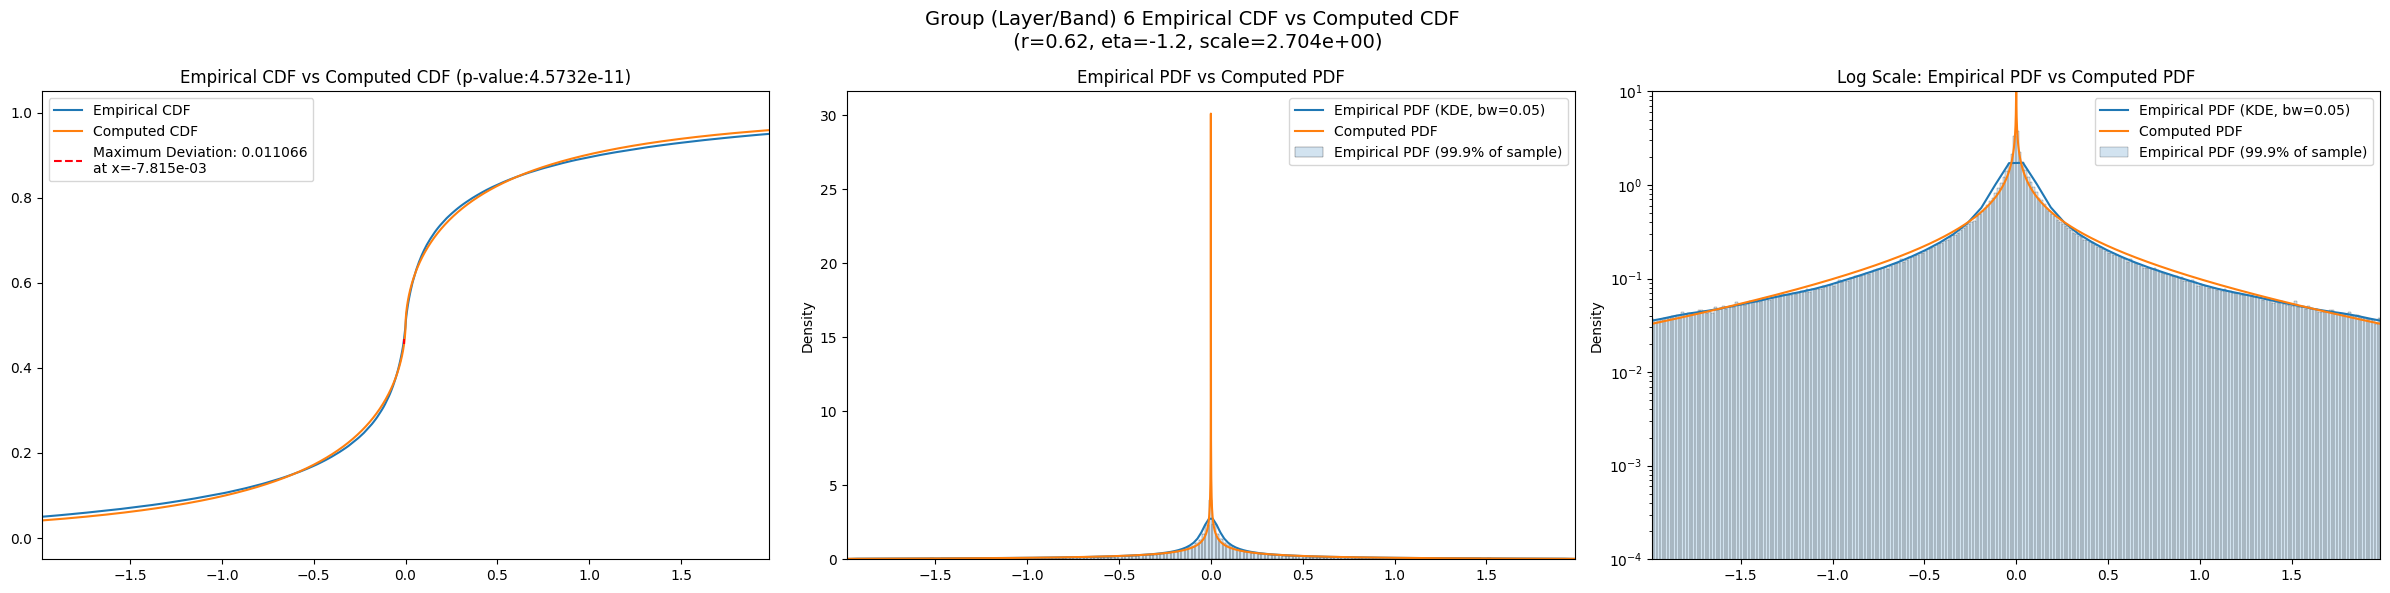

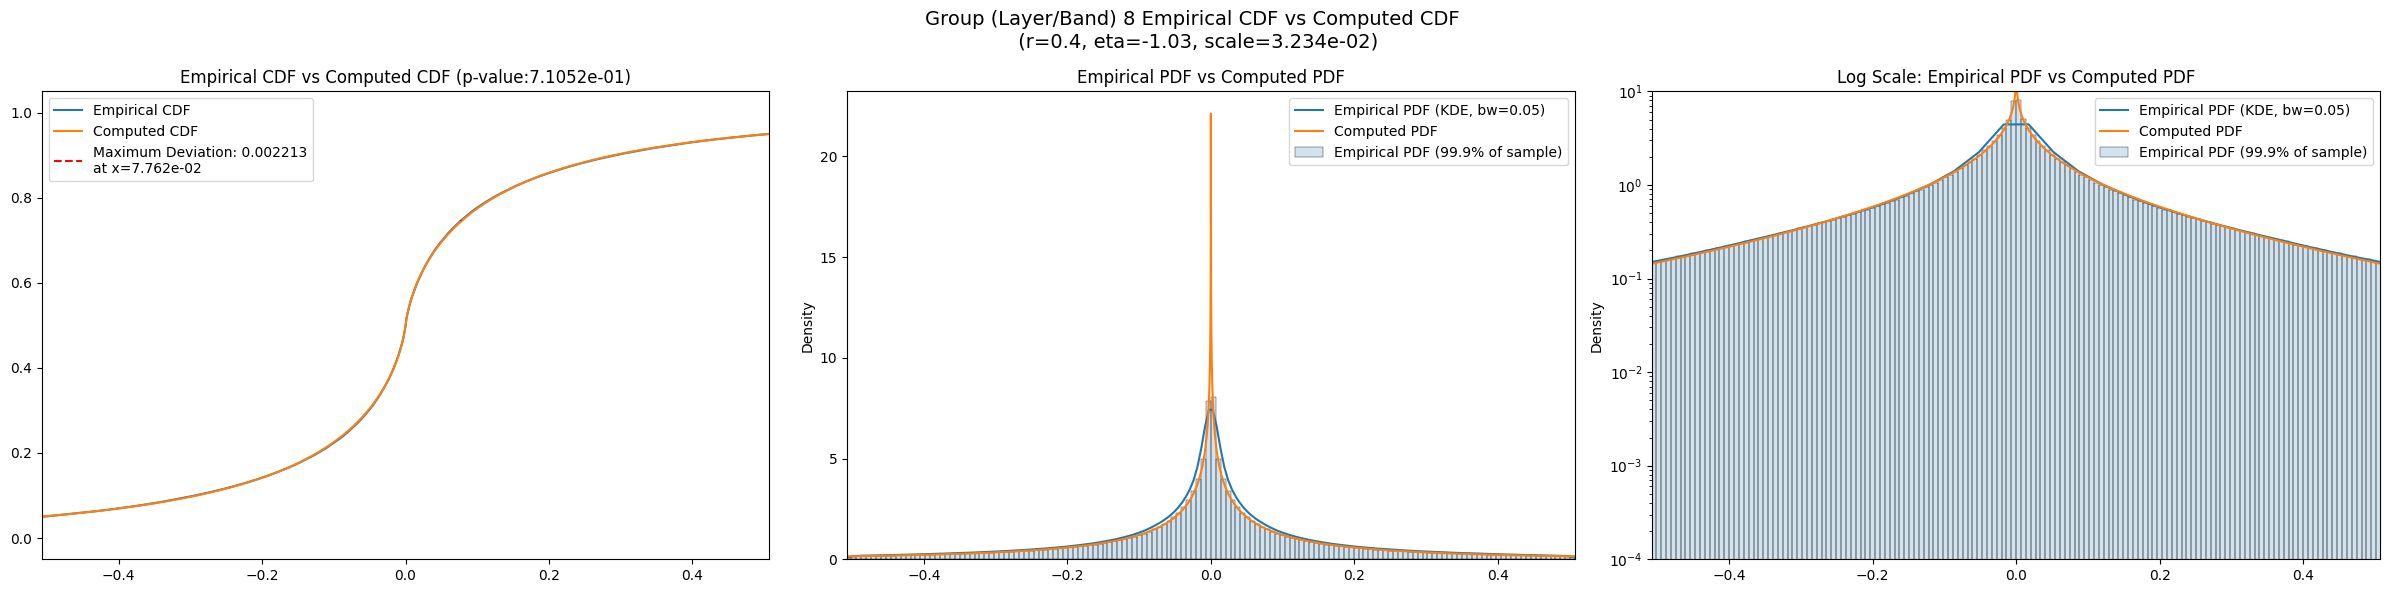

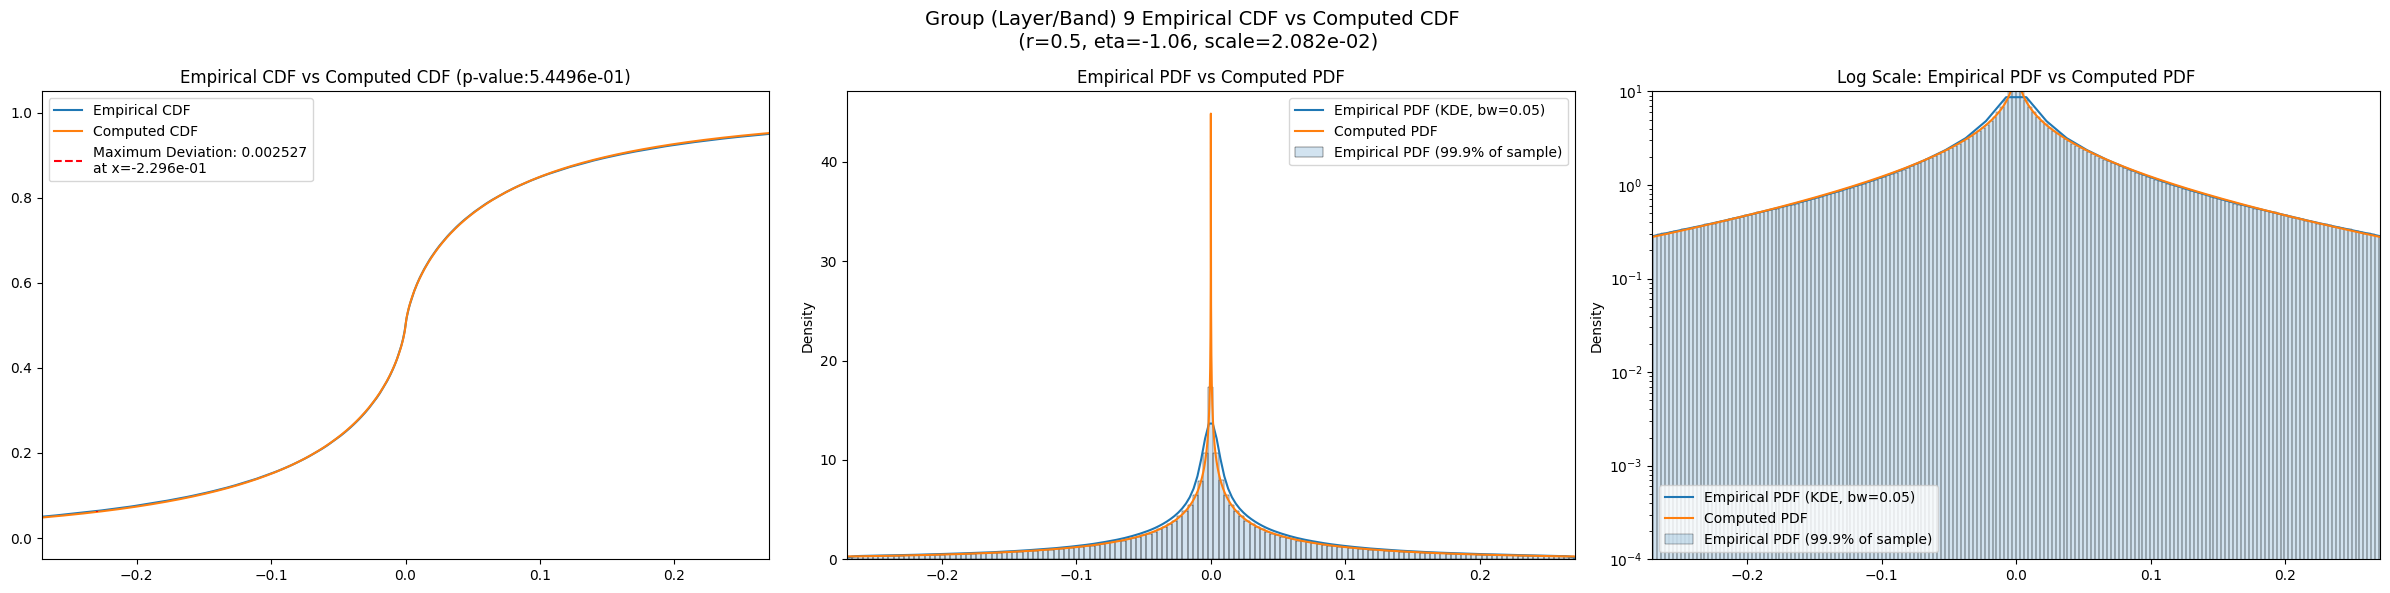

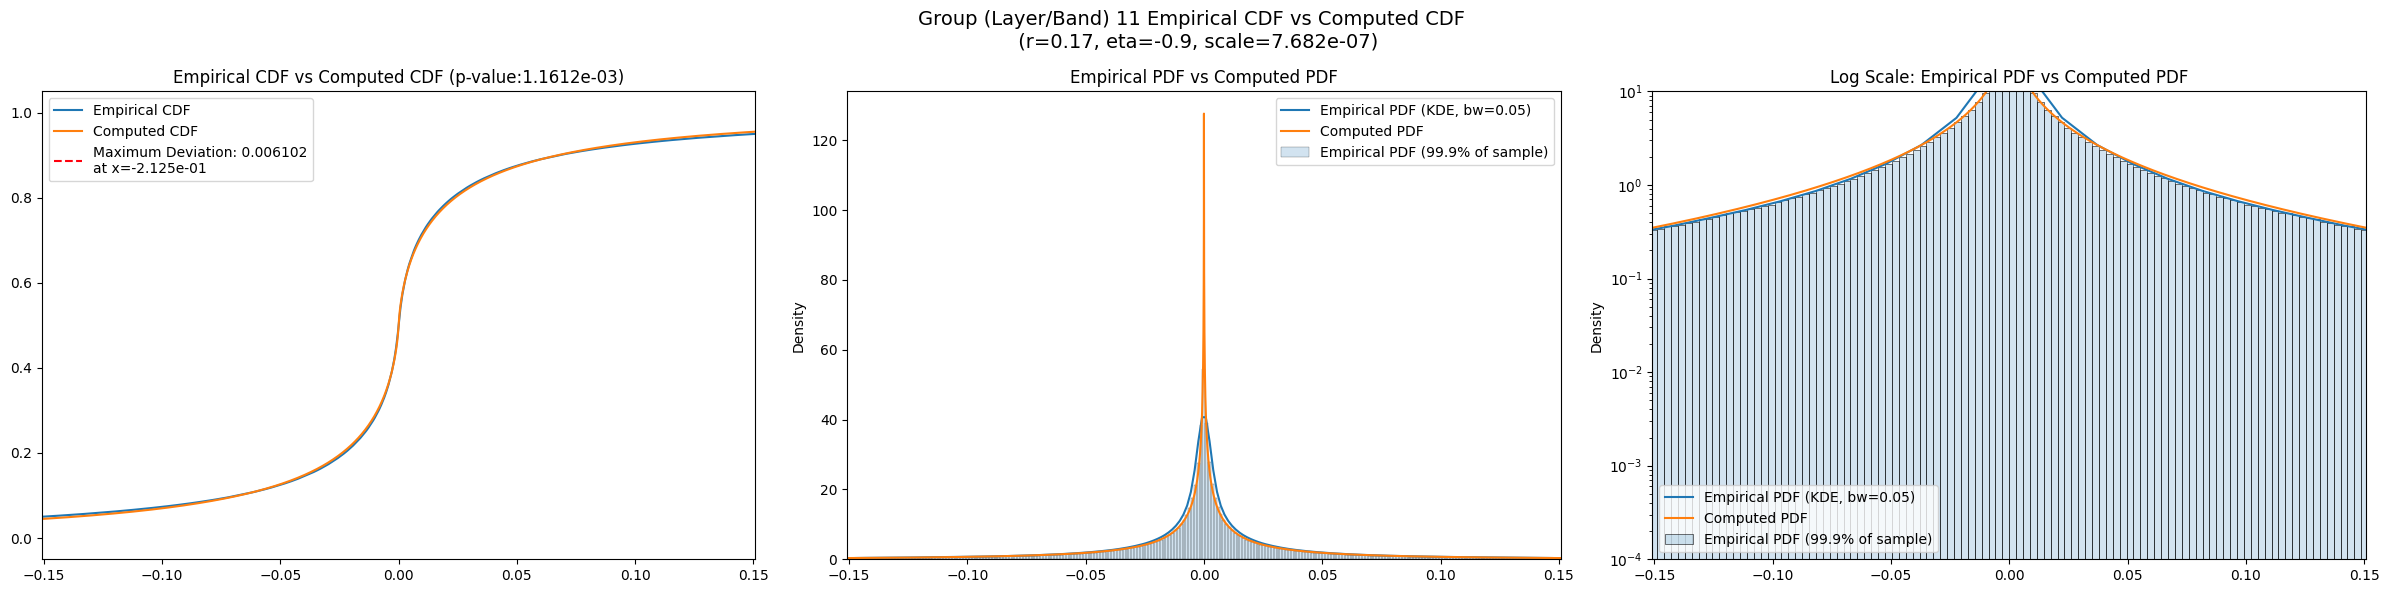

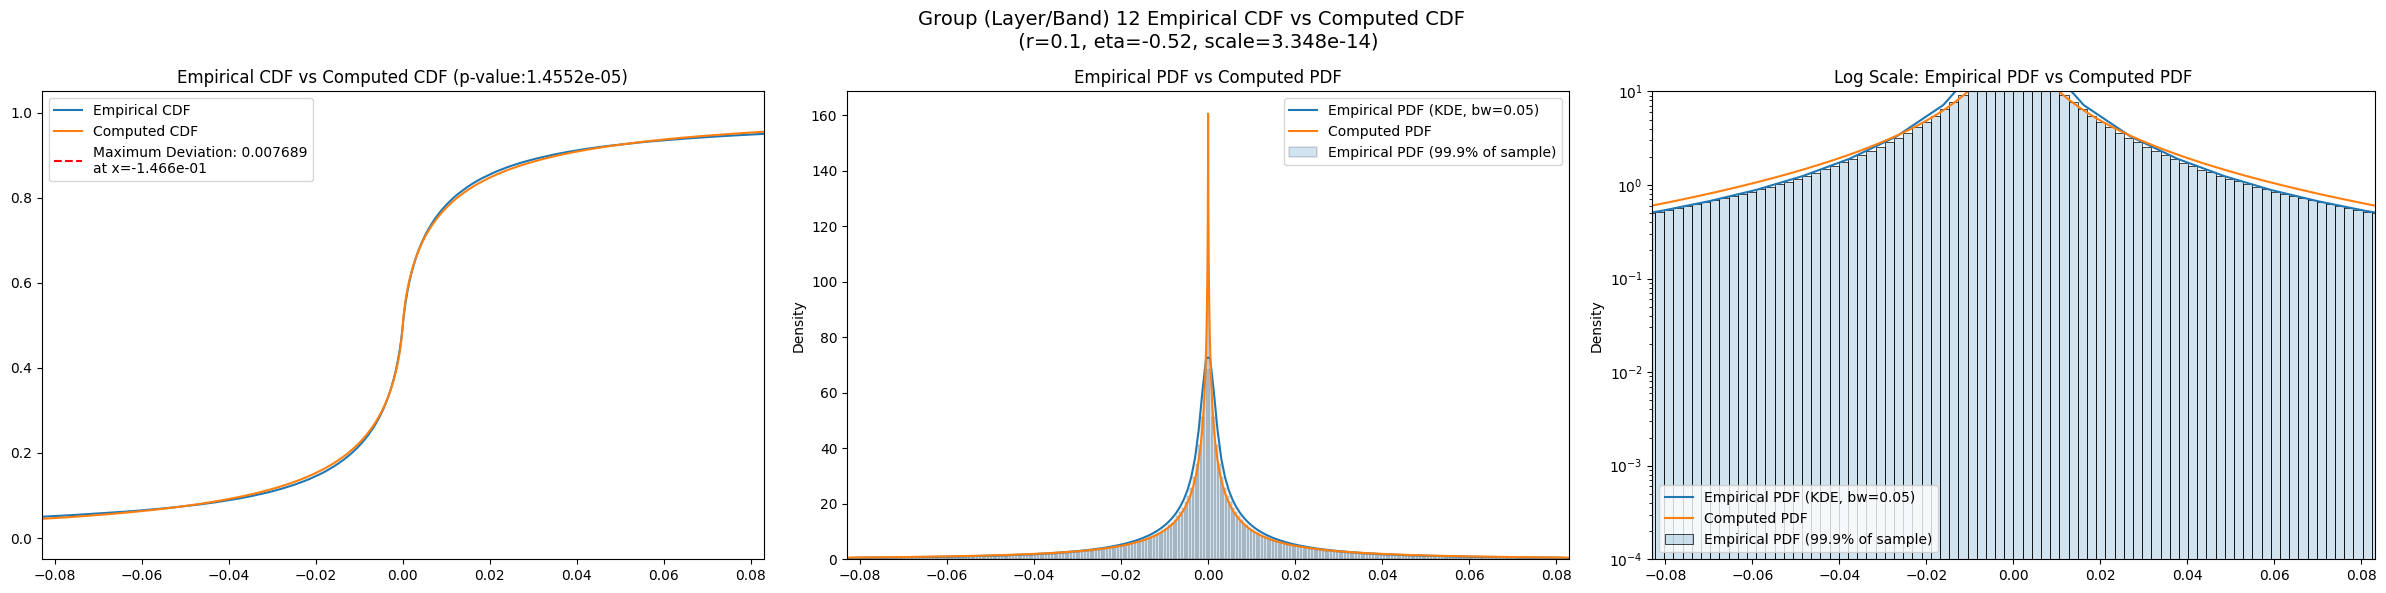

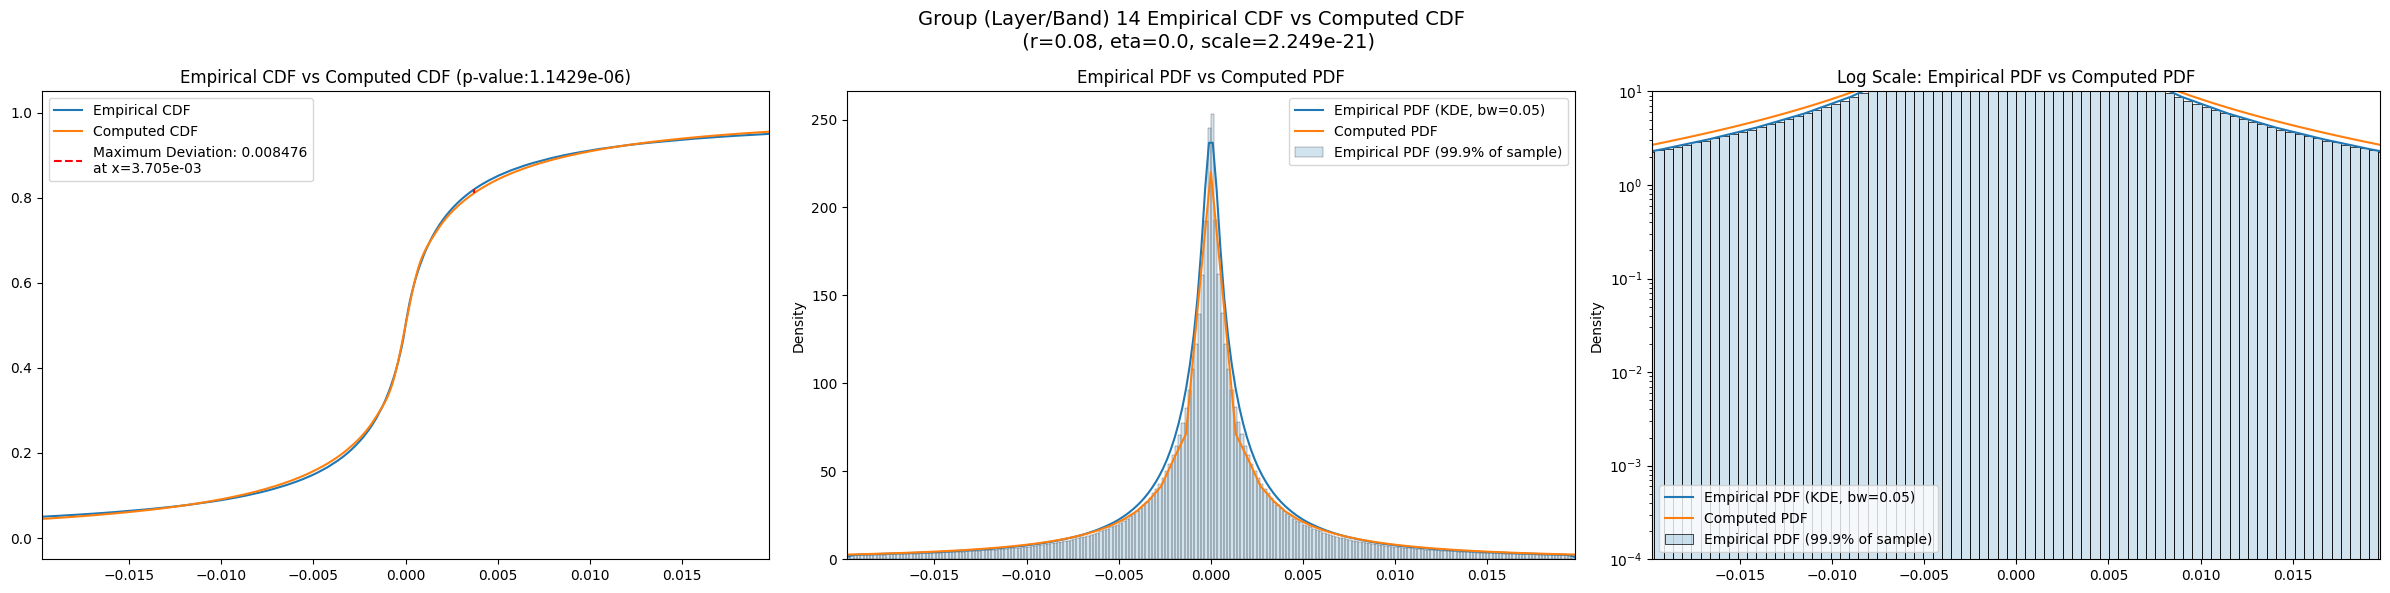

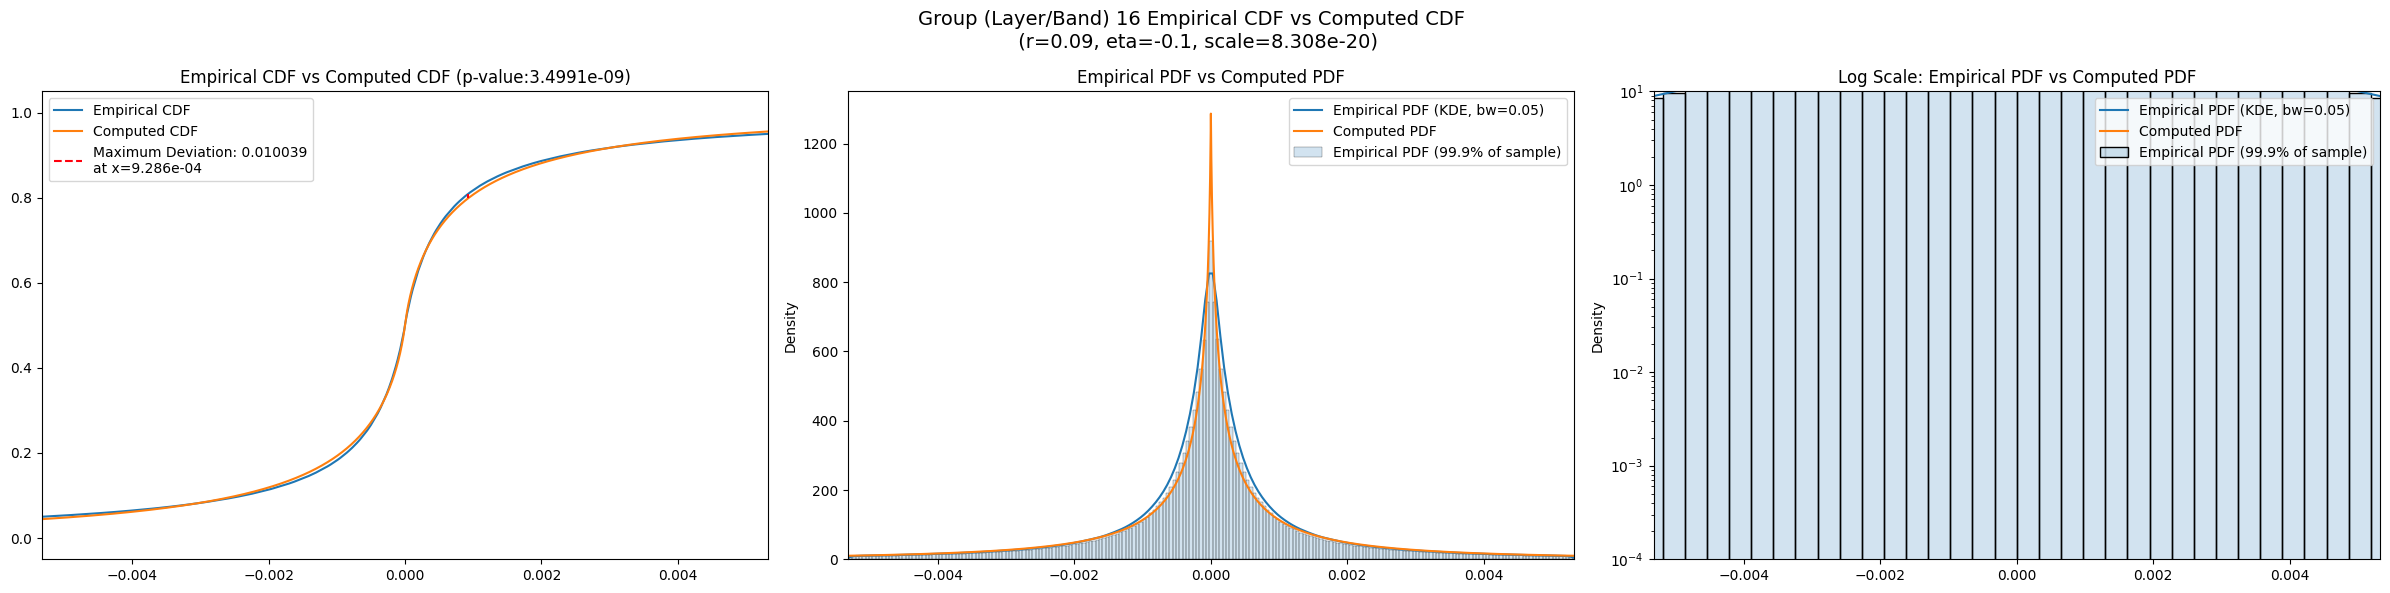

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     0.013561   0.011274   0.016338   49.807297   26.193740   76.981925   
3     0.217521   0.182485   0.256708   41.785285   33.181702   52.732331   
5     2.124922   1.955512   2.299172    7.918936    6.897348    9.038367   
6     1.602871   1.474974   1.734341    7.894833    7.000770    8.838912   
8     0.153297   0.133375   0.176446   27.836279   17.204713   43.155848   
9     0.036959   0.032704   0.042303   22.688352   11.490171   58.108412   
11    0.023966   0.020228   0.028214   38.853258   27.268229   60.477741   
12    0.010845   0.008920   0.013193   55.613996   35.373178  103.036916   
14    0.000618   0.000498   0.000802   83.286215   35.822122  273.500316   
16    0.000156   0.000108   0.000227  212.922173   92.017210  500.892435   

      total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
band                                                              ...   
2           98143.0             0.002434        0.4         -0.8  ...   
3          100000.0             0.015278        0.1         -0.5  ...   
5          100000.0             0.010348        0.7         -1.2  ...   
6          100000.0             0.011352        0.6         -1.2  ...   
8          100000.0             0.003857        0.3         -0.9  ...   
9          100000.0             0.003219        0.6         -1.1  ...   
11         100000.0             0.008806        0.2         -1.0  ...   
12         100000.0             0.008402        0.1         -0.5  ...   
14         100000.0             0.009714        0.1         -0.3  ...   
16         100000.0             0.010904        0.1         -0.3  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           0.051472              0.057361         3.911510e-281   
3           0.059473              0.083926          0.000000e+00   
5           0.561117              0.090290          0.000000e+00   
6           0.461728              0.089962          0.000000e+00   
8           0.154371              0.072364          0.000000e+00   
9           0.084473              0.070303          0.000000e+00   
11          0.029740              0.089412          0.000000e+00   
12          0.015750              0.085372          0.000000e+00   
14          0.004374              0.078380          0.000000e+00   
16          0.001208              0.077701          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          0.044787             0.030745         4.998680e-81  0.035399   
3          0.054134             0.061605         0.000000e+00  0.040408   
5          0.478652             0.065852         0.000000e+00  0.370696   
6          0.398987             0.065296         0.000000e+00  0.306187   
8          0.133223             0.046469        4.381270e-188  0.104256   
9          0.072486             0.044938        6.343520e-176  0.056714   
11         0.025995             0.065517         0.000000e+00  0.019617   
12         0.013962             0.061738         0.000000e+00  0.010479   
14         0.003917             0.054177        1.511680e-255  0.002970   
16         0.001082             0.053271        4.379360e-247  0.000826   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.032790   4.102850e-92          8.740802e-01  
3          0.056522  3.950410e-278          4.643735e-17  
5          0.066991   0.000000e+00          1.509407e-07  
6          0.065180   0.000000e+00          4.573204e-11  
8          0.048046  4.772630e-201          7.105219e-01  
9          0.046826  5.496440e-191          5.449591e-01  
11         0.063962   0.000

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.002434                 0.004333          0.001890   
3                0.015278                 0.004293          0.013837   
5                0.010348                 0.004293          0.009054   
6                0.011352                 0.004293          0.011066   
8                0.003857                 0.004293          0.002213   
9                0.003219                 0.004293          0.002527   
11               0.008806                 0.004293          0.006102   
12               0.008402                 0.004293          0.007689   
14               0.009714                 0.004293          0.008491   
16               0.010904                 0.004293          0.010039   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.057361             0.030745       0.032790  
3                 0.083926             0.061605       0.056522  
5                 0.090290             0.065852       0.066991  
6                 0.089962             0.065296       0.065180  
8                 0.072364             0.046469       0.048046  
9                 0.070303             0.044938       0.046826  
11                0.089412             0.065517       0.063962  
12                0.085372             0.061738       0.058969  
14                0.078380             0.054177       0.050491  
16                0.077701             0.053271       0.049303

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2               0.010086          0.001890    0.38     -0.80  8.482768e-04   
3               0.144060          0.013837    0.10     -0.54  5.754224e-13   
5               2.124922          0.009054    0.65     -1.20  4.077315e+00   
6               1.543117          0.011066    0.62     -1.20  2.703689e+00   
8               0.141619          0.002213    0.40     -1.03  3.234321e-02   
9               0.034445          0.002527    0.50     -1.06  2.082015e-02   
11              0.021995          0.006102    0.17     -0.90  7.681850e-07   
12              0.009709          0.007689    0.10     -0.52  3.347668e-14   
14              0.000454          0.008491    0.08      0.00  2.249056e-21   
16              0.000029          0.010039    0.09     -0.10  8.307660e-20   

      best_exclude_cutoff  
band                       
2                   100.0  
3                   200.0  
5                     0.0  
6                    50.0  
8                    25.0  
9                    25.0  
11                   25.0  
12                   25.0  
14                  100.0  
16                  550.0